In [1]:
#%config IPCompleter.greedy = True
#%config Completer.use_jedi = False

In [507]:
#Array and Frames Libraries
import pandas as pd
import numpy as np
#Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
#Analyze distributions
from fitter import Fitter
#Machine Learning Libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import GammaRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
#Model Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
#Scoring
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
#Selection
from sklearn.feature_selection import VarianceThreshold
#Statistical Models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from patsy import dmatrices
#Regular Expressions Libraries
import re

# Constant Section

In [6]:
#Set all Visualization Parameters

#Parameters
visual_parameters = dict(
    {'figure.figsize': [20, 10], #Size of the plot
     'font.size': 15, #Font size
     'xtick.labelsize': 15, #Font size in X
     'ytick.labelsize': 15, #Font size in Y
     'xtick.direction': 'inout',
     'ytick.direction': 'inout',
})

#Apply all parameters
for parameter in visual_parameters:
    plt.rcParams[parameter] = visual_parameters[parameter]

#Apply Theme style
style = 'seaborn-darkgrid' #Theme style
plt.style.use(style)


In [7]:
#A list all Continuous Distributions available in Scipy
stats = [
    'alpha', 'anglit', 'arcsine', 'argus', 'beta',
    'betaprime', 'bradford', 'burr', 'burr12', 'cauchy',
    'chi', 'chi2', 'cosine', 'crystalball', 'dgamma',
    'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib',
    'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy',
    'foldnorm', 'genlogistic', 'gennorm', 'genpareto',
    'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 
    'genhalflogistic', 'geninvgauss', 'gilbrat', 'gompertz', 'gumbel_r',
    'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm',
    'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull',
    'johnsonsb', 'johnsonsu', 'kappa4', 'kappa3', 'ksone',
    'kstwo', 'kstwobign', 'laplace', 'laplace_asymmetric', 'levy',
    'levy_l', 'levy_stable', 'logistic', 'loggamma', 'loglaplace',
    'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke',
    'moyal', 'nakagami', 'ncx2', 'ncf', 'nct',
    'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw',
    'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'rice',
    'recipinvgauss', 'semicircular', 'kewnorm', 't', 'trapezoid',
    'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform',
    'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy'
]

In [828]:
#Pandas Parameters
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# All Functions defined for this Notebook
Here we can see all functions or methods needed

## Visualization Functions

In [10]:
#This is a simple method for drawing a plot x=numbers of observations and y=target values
def draw_plot(df, column, title):
    """
    DESCRIPTION
      This draw a plot and add a title
    ARGUMENTS
      df: This is the DataFrame where the data is stored
      column: The date column name
      title: The title of the plot
    RETURN
      One plot
    """
    
    #Prepare the Axes and size
    fig, ax = plt.subplots(1, 1)
    
    #Draw the plot with the right titles and labels
    ax.plot(df.index, df[column])
    ax.set_title(title)
    ax.set_xlabel('Obervations Range') 
    ax.set_ylabel(title)

In [953]:
#This show a scatter plot to see the mean and std relationship - Additive or Multiplicative
def draw_decomposition(df):
    """
    DESCRIPTION
      This draw a scatter plot x-axis: std and y-axis: mean and adjust with one line
      if the slope is around or more than 45º means the decomposition is multiplicative otherwise additive
    ARGUMENTS
      df: This is the DataFrame where the data is stored
    RETURN
      One plot
    """
    
    #Calculate the mean and std
    #data_small.groupby(['Year'])['Revenue'].std()
    mean_year = df.groupby(df.columns[0:1][0])[df.columns[-1]].mean()
    std_year = df.groupby(df.columns[0:1][0])[df.columns[-1]].std()
    
    #Create a new DataFrame with the Mean and Std per year
    data = pd.DataFrame([mean_year, std_year], index= ['Mean', 'Std']).T
    data.drop(data.index[6], inplace= True) # Remove 2021
    
    #Prepare the Axes and size
    sns.regplot(data['Mean'], data['Std']).set(title= 'Decomposition Analysis')

In [972]:
def draw_autocorrelation(df, mode, lags):
    """
    DESCRIPTION
      This draw an autocorrelation or partial autocorrelation chart based on parameter
    ARGUMENTS
      df: DataFrame where the data is stored
      mode: Type of correlation:
       'auto': Autocorrelation
       'partial': Partial autocorrelation
    RETURN
      One plot
    """

    #Check type of autocorrelation and draw it    
    if mode == 'auto':
        plot_acf(df[df.columns[-1]], lags= lags)
    elif mode == 'partial':
        plot_pacf(df[df.columns[-1]], lags= lags)
    
    #Horizontal lines around 0.2 correlation threshold
    plt.hlines(0.2, 0, lags, color= 'r', linestyles= 'dotted', linewidths= 5, alpha=0.5)
    plt.hlines(-0.2, 0, lags, color= 'r', linestyles= 'dotted', linewidths= 5, alpha=0.5)
    plt.show()

In [11]:
#This method draw for the target variable three different histograms versions, regular, logarithmic and square
def draw_set_of_distributions(df, column):
    """
    DESCRIPTION
      This function draw three different axes with these type of distributions:
      1.- Regular Distribution
      2.- Logarithmic Distribution
      3.- Square Distribution
    ARGUMENTS
      df: This is the DataFrame where the data is stored
      column: The date column name
    RETURN
      Three different frames
    """
    
    #Dictionary of distributions
    #It is a Tuple with the Array and Axes
    distributions = dict({
        'Regular Distribution': (df[column], 0),
        'Logarithmic Transformation': (np.log1p(df[column]), 1),
        'Square Transformation': (np.sqrt(df[column]), 2)
    })
    
    #Prepare the Axes and size
    fig, ax = plt.subplots(3, 1)
    fig.set_size_inches(20,20)
    
    #Get the bins for the variable
    bins = get_bins(df, column)
    
    #Draw the different distributions
    for distribution in distributions:
        #Get the values and axe for each Distribution
        values = distributions[distribution][0]
        axe = distributions[distribution][1]
        #Draw the Distribution and Title
        sns.histplot(values, bins= bins, kde= True, stat= "density", ax= ax[axe])
        sns.rugplot(values, ax= ax[axe])
        #sns.distplot(values, hist= True, bins= bins, rug= True, ax= ax[axe])
        ax[axe].set_title(distribution)

In [12]:
#This method draw a grid with a Histogram by feature
def draw_distribution(df, columns):
    """
    DESCRIPTION
      This function draw a distribution analysis per feature
    ARGUMENTS
      df: This is the DataFrame where the data is stored
      column: This is the column list to draw
    RETURN
      Multiple distribution based on the columns values
    """
    
    #We need to transform the parameter into a list in case there is only one column
    columns = list(columns)
    
    #Prepare the Axes and size
    #Always, it will be 3 columns by rows based on the numbers of variables
    rows = 1 + int(len(columns)/3) if len(columns) % 3 == 2 else len(columns) % 3 + int(len(columns)/3)
    fig, ax = plt.subplots(rows, 3)
    #Let's convert NxM Array into N
    ax = ax.flat
    fig.set_size_inches(20,20)
    
    #Iterate in all columns
    for i, column in enumerate(columns):
        #Get the bins for the variable
        bins = get_bins(df, column)
        #if no bins, let's use by default
        if bins == 0:
            sns.histplot(df[column], kde=True, stat= "density", ax= ax[i])
        else:
            sns.histplot(df[column], bins= bins, kde=True, stat= "density", ax= ax[i])
        ax[i].set_title(column)
    fig.tight_layout()
    plt.subplots_adjust(top= 0.9)
    fig.suptitle('Features Distributions', fontsize= 25)

In [13]:
#This draw a correlation grid Target vs. Feature
def draw_correlation(df, columns, target):
    """
    DESCRIPTION
      This function draw the correlation between each feature and the objective
    ARGUMENTS
      df: This is the DataFrame where the data is stored
      column: This is the column list with all features
      target: This is the target value to correlate which each feature
    RETURN
      Multiple regression linear plots for pair - target vs feature
    """
    
    #We need to transform the parameter into a list in case there is only one column
    columns = list(columns)
    
    #Prepare the Axes and size
    #Always, it will be 3 columns by rows based on the numbers of variables
    rows = 1 + int(len(columns)/3) if len(columns) % 3 == 2 else len(columns) % 3 + int(len(columns)/3)
    fig, ax = plt.subplots(rows, 3)
    #Let's convert NxM Array into N
    ax = ax.flat
    fig.set_size_inches(20,20)
    
    #Iterate in all columns
    for i, column in enumerate(columns):
        sns.regplot(x= df[column], y= df[target], marker= 'x', 
                scatter_kws= {"alpha": 0.4}, line_kws= {"color": "r","alpha": 0.7}, ax= ax[i])
        ax[i].set_title(f'{column} correlation with {list(target)[0]}')
        
    fig.tight_layout()
    plt.subplots_adjust(top= 0.9)
    fig.suptitle('Correlation Analysis', fontsize= 25)

In [14]:
#This function gives you the right bins proportion
def get_bins(df, column):
    """
    DESCRIPTION
      This function returns the right proportion of bins needed
    ARGUMENTS
      df: This is the DataFrame to calculate the bins
      column: The date column name
    RETURN
      The h of the bins
    """
    
    #Formula is Max Value - Min Value / Number of Observations
    return int((df[column].max() - df[column].min()) / len(df[column]))

In [15]:
#This function return a correlation Heatmap
def corr_matrix (df):
    """
    DESCRIPTION
      This function draw the correlation matrix across the variables
    ARGUMENTS
      df: This is the DataFrame where the data is stored
    RETURN
      A Heatmap
    """
    
    #Calculate correlation
    corr = df.corr()
    #Keep just diagonal and below
    data = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
    #Heatmap Size - plt.subplots(figsize=(20, 10)) - fig.set_size_inches(20,10)
    f, ax = plt.subplots(figsize=(20, 10))
    #Background color, it has to set at axe level because it is not working if we change axes.facecolor value
    #and then set a style because override that value
    ax.set_facecolor('white')
    ax = sns.heatmap(data, cmap='Spectral', annot= True, center= -0.1)

In [16]:
#This function shows the differences between real y and predicted ŷ
def draw_predict(model, X_real, y_real):
    """
    DESCRIPTION
      This plot real values versus predicted values
    ARGUMENTS
      model: Regression model to apply predict
      X_real: Real features
      y_real: Real objective or dependant variable
    RETURN
      Draw a plot
    """
    
    #Get the predictions
    y_pred = model.predict(X_real)
    print(f'{type(model).__name__} | Predict MAE: {mean_absolute_error(y_real,y_pred):.4f}')
    print(f'{type(model).__name__} | Predict RMSE: {np.sqrt(mean_squared_error(y_real,y_pred)):.4f}')
    print(f'{type(model).__name__} | Predict R2: {r2_score(y_real,y_pred):.4f}')
    
    #Plot the real Ys versus Y predicted
    fig = plt.figure()
    fig.set_size_inches(20,10)
    plt.plot(range(X_real.iloc[:,0].count()), y_real)
    plt.plot(range(X_real.iloc[:,0].count()), y_pred, c='r', linewidth=3)

## Data Manipulation Functions

In [396]:
#Clean the zero Revenue in the original DataFrame
def fill_zero_revenue(df):
    """
    DESCRIPTION
      This function complete the zero values in Revenue pero tracking issues in Omniture. We are going to use the
      mean between date after and before and apply this new Revenue to Direct Program
    ARGUMENTS
      df: This is the DataFrame to clean
    RETURN
      A new DataFrame with the Revenue zero values cleaned
    """
    
    #Clone the current DataFrame
    data = df.copy()
    
    #Let's calculate what dates have zero Revenue because we are using that values for pivoting
    temp_df = data.groupby(['Date'])['Revenue'].sum().reset_index()
    zero_revenue_dates = temp_df[temp_df['Revenue'] == 0]['Date']
    
    #Prepare the range of dates +1 and -1 Day considering the data with zero Revenue
    date_after = zero_revenue_dates - np.timedelta64(-1,'D')
    date_before = zero_revenue_dates - np.timedelta64(1,'D')
    
    #Create Series with the Revenue
    revenue_after = data[data['Date'].isin(date_after)].groupby('Date')['Revenue'].sum()
    revenue_before = data[data['Date'].isin(date_before)].groupby('Date')['Revenue'].sum()
    
    #Create a DataFrame with the two Revenue Columns -1 and +1 and calculate the mean
    revenue_df = pd.DataFrame([revenue_before.values, revenue_after.values], index= ['after', 'before']).T
    revenue_mean = revenue_df.mean(axis=1)
    
    data.loc[(data['Date'].isin(fechas)) & (data['Program'] == 'Direct'), 'Revenue'] = revenue_mean.values
    
    return data

In [17]:
#Convert Date into Year, Month and Day
def split_dates_by_columns(df, column):
    """
    DESCRIPTION
      This function returns a new DataFrame extracting year, month and day from a date column
    ARGUMENTS
      df: This is the DataFrame to manipulate
      column: The date column name
    RETURN
      A new DataFrame with 3 new columns related to the date and removing the Date column
    """
    
    #This is the returned DataFrame
    data = pd.DataFrame()
    
    #Add the new columns
    data['Year'] = df[column].dt.year
    data['Month'] = df[column].dt.month
    data['Day'] = df[column].dt.day
    
    #Let's take all columns except the Date one
    columns = set(df.columns) - set([column])
    
    #Return the merge Dataframes
    return pd.concat([data, df[columns]], axis= 1)

In [18]:
#Convert Date into ISO Year, ISO Week and Day
def split_dates_by_iso_columns(df, column):
    """
    DESCRIPTION
      This function returns a new DataFrame extracting ISO year, ISO week and day from a date column
    ARGUMENTS
      df: This is the DataFrame to manipulate
      column: The date column name
    RETURN
      A new DataFrame with 3 new columns related to the date and removing the Date column
    """
    
    #This is the returned DataFrame
    data = pd.DataFrame()
    
    #Invoke the method which creates a new DataFrame with Year, Week and Day and Capitalize the Header
    data = df[column].dt.isocalendar()
    data.columns = data.columns.str.capitalize()
    
    #Let's take all columns except the Date one
    columns = set(df.columns) - set([column])
    
    #Return the merge Dataframes
    return pd.concat([data, df[columns]], axis= 1)

In [19]:
#Group some traffic sources into Direct and Display based on some specific rules
def group_programs(df):
    """
    DESCRIPTION
      This function returns a new DataFrame just keeping the main programs: Direct, SEO, SEM, Affiliate, Email and Display
    ARGUMENTS
      df: This is the DataFrame to group
    RETURN
      A new DataFrame with only those Programs
    """
    
    #Create a copy of the DataFrame
    data = df.copy()
    
    #Now, we have two main sets, selected_programs what we want to keep
    #And sub_programs which contain the remaining Programs to merge with two Direct and Display
    all_programs = set(data['Program'].unique())
    selected_programs = set(['Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display'])
    sub_programs = all_programs - selected_programs
    
    #We are going to create two subsets one which will have all Programs to merge with Direct
    #And another one to merge with Display
    new_display = set()
    for i in sub_programs:
        if 'Social' in i:
            new_display.add(i)
    new_direct = sub_programs - new_display
    
    #Just rename all new_direct Programs as Direct and same with Display
    data.loc[(data['Program'].isin(list(new_direct))), 'Program'] = 'Direct'
    data.loc[(data['Program'].isin(list(new_display))), 'Program'] = 'Display'
    
    return data

In [20]:
#Add two new qualitative columns, Black Friday=1 and Cyber Monday=1
def get_black_friday_cyber_monday(df):
    """
    DESCRIPTION
      This function returns a new DataFrame with a new Black Friday and Cyber Monday column
    ARGUMENTS
      df: This is the DataFrame with Year and Week columns
    RETURN
      A new DataFrame with 2 new columns
    """
    
    #Create a copy of the DataFrame
    data = df.copy()
    #These are the dictionaries when a Black Friday or Cyber Monday takes place
    bf_dict = {47:[2016, 2017, 2018, 2021],
          48:[2015, 2019, 2020]}
    cm_dict = {48:[2016, 2017, 2018, 2021],
          49:[2015, 2019, 2020]}
    
    data['Black_Friday'] = 0
    data['Cyber_Monday'] = 0
    #
    for week in bf_dict:
        data['Black_Friday'][data['Year'].isin(bf_dict[week]) & (data['Week'] == week)] = 1
    for week in cm_dict:
        data['Cyber_Monday'][data['Year'].isin(cm_dict[week]) & (data['Week'] == week)] = 1
    
    return data

In [21]:
#This could be the main function to return the final DataFrame with all manipulations
def dataframe_preparation(df):
    """
    DESCRIPTION
      This function returns a new DataFrame with all Columns well sorted and normalized
    ARGUMENTS
      df: This is original DataFrame to manipulate
    RETURN
      A new DataFrame with Xs Values: Year, Week, Black Friday, Cyber Monday, Direct, SEO, SEM, Affiliate, Email, Display and Y Value: Revenue
    """
    
    #Clone the current DataFrame
    data = df.copy()
    #First of all manipulate the Date column and split into Year, Month, Day and Year-Week
    data = split_dates_by_iso_columns(data, 'Date')
    
    #Let's keep the columns needed
    #Because we are going to use ISO Week and ISO Year, we are not going to use Month
    data = data[['Year', 'Week', 'Program', 'Visits', 'Revenue']]
    
    #We are not going to work with all Programs, just SEO, Direct, SEM, Display, Affiliate and Email
    #We are going to sum in the Display bucket Paid Social, Organic Social, Lenovo Social and Social
    #And the rest will go to the Direct bucket
    data = group_programs(data)
    
    #Now let's build the Xs - Features. Program for us is similar to Traffic Sources
    program_data = data.groupby(['Year', 'Week', 'Program'])['Visits'].sum().unstack().fillna(value = 0).reset_index()
    #In this phase we need to add two categorial variables - Black Friday and Cyber Monday in this DataFrame
    bf_cm_data = get_black_friday_cyber_monday(program_data.iloc[:,0:2])
    
    #Now let's build the Y - Revenue. We are using as primary key for merging Year and Week
    revenue_data = data.groupby(['Year', 'Week'])['Revenue'].sum().reset_index()
    
    #DataFrame is ready
    return pd.concat([bf_cm_data, 
                      program_data[['Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display']], 
                      revenue_data['Revenue']], axis= 1)

Machine Learning Functions

In [22]:
#Variance features analysis
def non_zero_variance(df, columns):
    """
    DESCRIPTION
      This function analyze the standard deviation for each feature
    ARGUMENTS
      df: This is the DataFrame to analyze
      columns: A list of columns with the features
    RETURN
      What feature has non-zero and zero variance
    """
    
    selector = VarianceThreshold()
    selector.fit_transform(columns)
    
    non_zero = set(df.columns[selector.get_support(indices=True)])
    zero = set(df.columns) - set(list([df.columns[-1]])) - non_zero
    
    for i in non_zero:
        print(f'{i} feature: has non-zero variance - Std:{np.std(df[i]):.2f}')
    for i in zero:
        print(f'{i} feature: has zero variance and should be removed  - Std:{np.std(df[i]):-2f}')

In [23]:
#Return the X and y for splitting
def data_preparation(df):
    """
    DESCRIPTION
      This function returns a X Pandas set for splitting or predict and y Series for splitting or predict
    ARGUMENTS
      df: This is the DataFrame from get train and test data
    RETURN
      A new DataFrame with Xs Values: Year, Week, Black Friday, Cyber Monday, Direct, SEO, SEM, Affiliate, Email, Display
      and Y Value: Revenue
      IMPORTANT: DataFrame columns order should be <all features><target> this mean, last column is the target
    """
    
    X = df.columns[0:-1] # pandas DataFrame
    y = df.columns[-1] # pandas Series
    
    return df[X], df[y]

In [24]:
#Return the Xs and ys for test and train
def data_split(X, y):
    """
    DESCRIPTION
      This function returns the set for training and test
    ARGUMENTS
      X: It is a DataFrame with the features
      y: It is a Series with the objective
    RETURN
      The X Train and Test and y Train and Test
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 1)
    return X_train, X_test, y_train, y_test

In [796]:
#Return a normalized DataFrame based on two scaler Norm and Robust
def data_normalization(df, scale_param):
    """
    DESCRIPTION
      This function returns a new DataFrame with all elements normalized based on scale method
    ARGUMENTS
      df: DataFrame to normalize
      scaler: Type of normalization:
       'norm': StandarScaler
       'robust': RobustScaler
       'power': PowerTransformer
    RETURN
      New DataFrame normalized
    """
    
    #Dictionaries of scaling methods
    methods = {'norm': StandardScaler(),
               'robust': RobustScaler(),
               'power': PowerTransformer()}
    #Data Normalization
    scaler = methods[scale_param]
    columns = df.columns
    
    return pd.DataFrame(scaler.fit_transform(df), columns= columns)

In [26]:
#This is a metric for measuring the bias and variance (tradeoff)
def bias_variance(model, X_real, y_real, tradeoff):
    """
    DESCRIPTION
      This function returns the Bias or Variance for a model
    ARGUMENTS
      model: Regression model to apply predict
      X_real: Real features
      y_real: Real objective or dependant variable
      tradeoff: What type of metric to apply in the model
    RETURN
      Bias or Variance
    """
        
    #Predict
    y_pred = model.predict(X_real)
    #Bias or Variance metric
    if tradeoff == 'variance':
        return np.corrcoef(y_pred, y_real)[0][1]
    elif tradeoff == 'bias':
        return np.mean(y_pred - y_real)

## Analysis Functions 

In [573]:
#Augmented Dickey-Fuller Test
def test_adf(df, column):
    """
    DESCRIPTION
      This function calculate the Augmented Dickey-Fuller Test to proof
      H0 if p-value > 0.05 or T-Test is bigger than critical values interval - No stationary
      H1 if p-value < 0.05 or T-Test is smaller than critical values interval - Stationary
    ARGUMENTS
      df: This is the DataFrame with the data
      column: Variable to apply the test
    RETURN
      If it is a stationary or not variable
    """
    
    interval = list(['1%', '5%', '10%'])
    greater_smaller = lambda x, y: '<' if x < y else '>'
    check = lambda x, y: 'Stationary' if x < y else 'No Stationary'
    h0 = False
    
    adf = adfuller(df[column])
    t_test = adf[0]
    p_value = adf[1]
    t_interval = adf[4]
    
    print('** Augmented Dickey-Fuller Test **\n')
    for i in t_interval:
        print(f'T-test: {t_test} {greater_smaller(t_test, t_interval[i])} Confidence Interval: {t_interval[i]} - Result: {check(t_test, t_interval[i])}')
    
    print(f'\nP-Value: {p_value} {greater_smaller(p_value, 0.05)} 0.05 - Result: {check(p_value, 0.05)}')     

First of all get all data and create a dataframe for them, I have included year, month and day
Next time, i will use some formula for making those calculations

In [406]:
#Data set to train
my_train_file = "./data_v1.xlsx"
data = pd.read_excel(my_train_file)
data

,Date,Program,Visits,Revenue
0,2015-01-01 23:59:59,SEO,0,2317.14
1,2015-01-01 23:59:59,SEO,0,903.10
2,2015-01-01 23:59:59,SEO,2844,0.00
3,2015-01-01 23:59:59,Direct,0,24.31
4,2015-01-01 23:59:59,Direct,937,0.00
...,...,...,...,...
104788,2021-04-11 23:59:59,::unspecified::,14,0.00
104789,2021-04-11 23:59:59,Paid Social,179,0.00
104790,2021-04-11 23:59:59,Organic Social,143,0.00
104791,2021-04-11 23:59:59,Other,1,0.00


In [407]:
#Data set to predict
my_predict_file = "./data_predict_v1.xlsx"
data_predict = pd.read_excel(my_predict_file)
data_predict

,Date,Program,Visits,Revenue
0,2021-04-12 23:59:59,Direct,1,2484.69
1,2021-04-12 23:59:59,Direct,1,1988.53
2,2021-04-12 23:59:59,Direct,1,1984.02
3,2021-04-12 23:59:59,Direct,1,1696.85
4,2021-04-12 23:59:59,Direct,1,1568.62
...,...,...,...,...
1898,2021-05-09 23:59:59,::unspecified::,21,0.00
1899,2021-05-09 23:59:59,Paid Social,1050,0.00
1900,2021-05-09 23:59:59,Organic Social,19,0.00
1901,2021-05-09 23:59:59,Other,4,0.00


# Exploratory Data Analysis

Let's analyze what is the size of our observations and columns. Is there any Nan or check the type of the data. This should be the starting point of any Data Science Project

In [29]:
#Dimension of the Dataset
data.shape
#More than 104K records and 4 columns

(104793, 4)

In [30]:
#Let's check if there is any NaN
data.isna().sum()

Date       0
Program    0
Visits     0
Revenue    0
dtype: int64

In [31]:
data.dtypes

Date       datetime64[ns]
Program            object
Visits              int64
Revenue           float64
dtype: object

In [408]:
#Let's check if there is a zero value in Revenue
check = data.groupby(['Date'])['Revenue'].sum().reset_index()
check_zeros = check[check['Revenue'] == 0]
check_zeros

,Date,Revenue
66,2015-03-08 23:59:59,0.0
163,2015-06-13 23:59:59,0.0
387,2016-01-23 23:59:59,0.0
450,2016-03-26 23:59:59,0.0
924,2017-07-13 23:59:59,0.0
1930,2020-04-14 23:59:59,0.0


In [409]:
#There are some and we are going to estimate the Revenue, we are going to use the 
#Mean between Revenue day before and day after and we are going to apply that one to Direct Traffic
data = fill_zero_revenue(data)
data_predict = fill_zero_revenue(data_predict)

# Distribution Analysis

It is important analyze the Revenue behave. We are going to exclude the Program Variable and just keep Year, Month, Day, Visits and Revenue.

In [410]:
data

,Date,Program,Visits,Revenue
0,2015-01-01 23:59:59,SEO,0,2317.14
1,2015-01-01 23:59:59,SEO,0,903.10
2,2015-01-01 23:59:59,SEO,2844,0.00
3,2015-01-01 23:59:59,Direct,0,24.31
4,2015-01-01 23:59:59,Direct,937,0.00
...,...,...,...,...
104788,2021-04-11 23:59:59,::unspecified::,14,0.00
104789,2021-04-11 23:59:59,Paid Social,179,0.00
104790,2021-04-11 23:59:59,Organic Social,143,0.00
104791,2021-04-11 23:59:59,Other,1,0.00


In [411]:
#Manipulate the DataFrame a little bit. Modifying the Dates
data_small = split_dates_by_columns(data, 'Date')
#For this early stage I discard type of Traffic and just sum all of them and group by Year, Month and Day
data_small = data_small.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()
#Reset Index after having made a groupby
data_small = data_small.reset_index()
data_small.head(5)

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52


In [412]:
#Lets check it out how this looks like and we can see that we have 2293 rows of data. Original one was 104793 rows
data_small.shape

(2293, 5)

In [413]:
#Let's see the main descriptive statistics
data_small.describe()

,Year,Month,Day,Visits,Revenue
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,2017.654601,6.332316,15.678151,13369.372874,25749.816946
std,1.818372,3.492998,8.807136,8632.318322,38720.020085
min,2015.000000,1.000000,1.000000,245.000000,46.420000
25%,2016.000000,3.000000,8.000000,7839.000000,9709.990000
50%,2018.000000,6.000000,16.000000,10166.000000,18378.690000
75%,2019.000000,9.000000,23.000000,16190.000000,32715.600000
max,2021.000000,12.000000,31.000000,109148.000000,858333.560000


In [414]:
#High Variability in Revenue
pearson_revenue = data_small['Revenue'].std() / data_small['Revenue'].mean()
#Visit Variability is less than Revenue but it is above 0.5
pearson_traffic = data_small['Visits'].std() / data_small['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue}) and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 1.5037007900515906) and Pearson Visits: 0.6456786270337299


We can see how the Revenue evolution across time. There are some big outliners due to the BlackFriday and Cyber Monday. Those exceptional days could affect in our model but we cannot remove them. However, maybe we can create a specific model for those ones and remove them for this model. Let's see

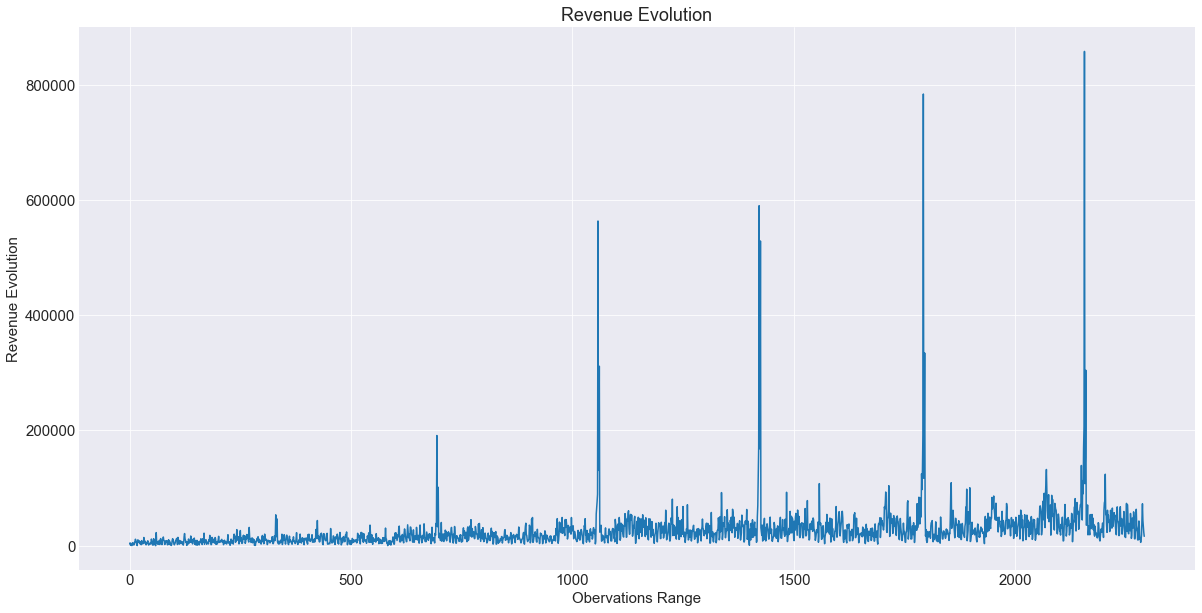

In [415]:
draw_plot(data_small, 'Revenue', 'Revenue Evolution')

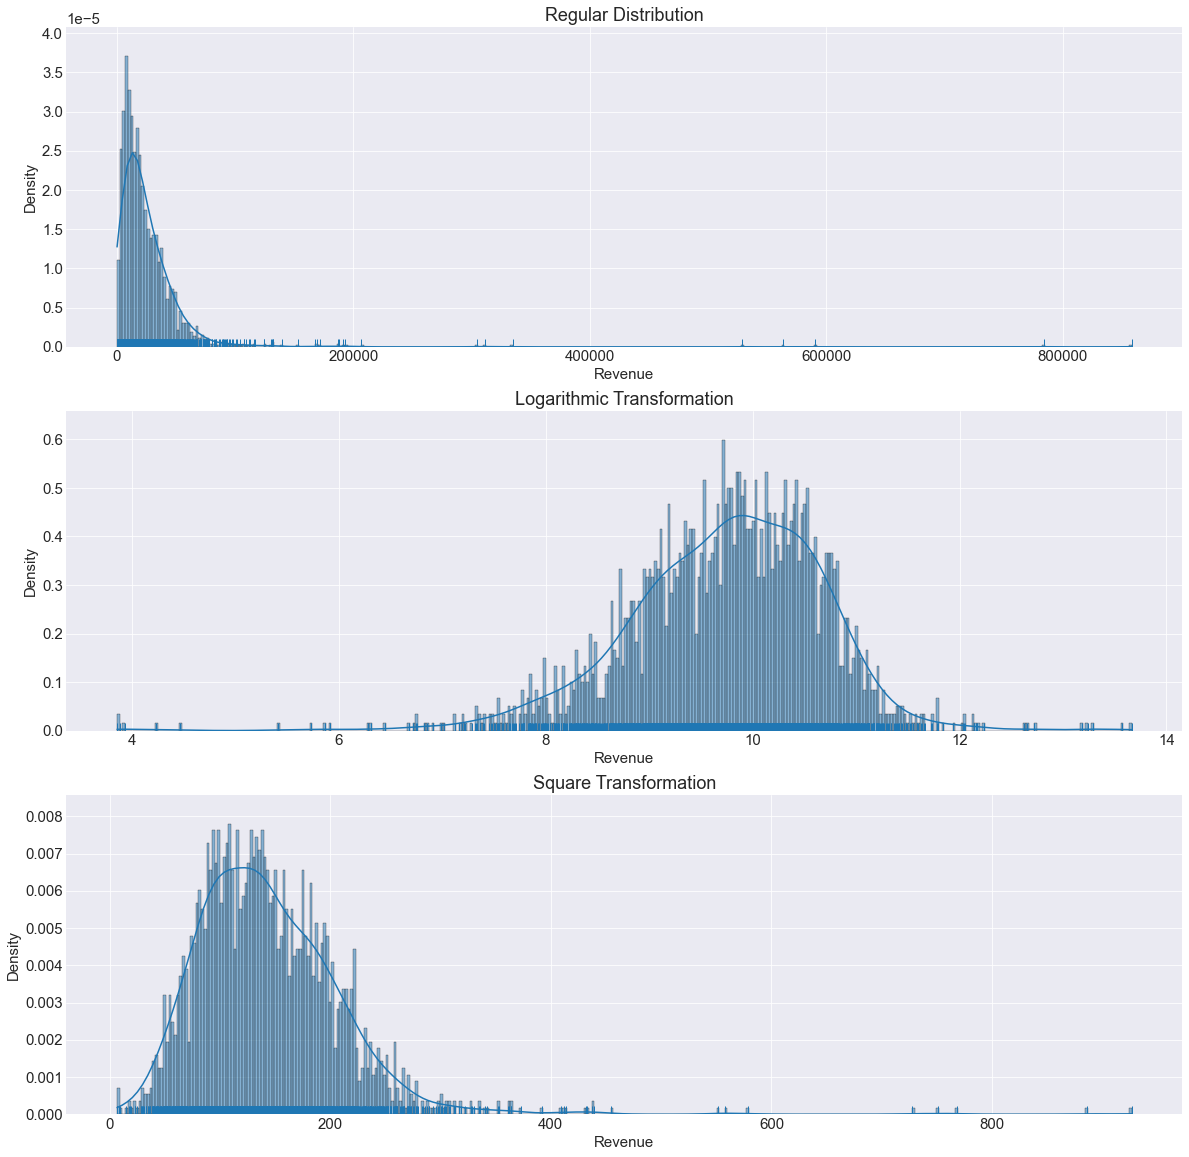

In [416]:
draw_set_of_distributions(data_small, 'Revenue');

/home/dsc/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


{'lognorm': (0.7769198319912645, -2207.4464286059147, 20132.90162753572)}

/home/dsc/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


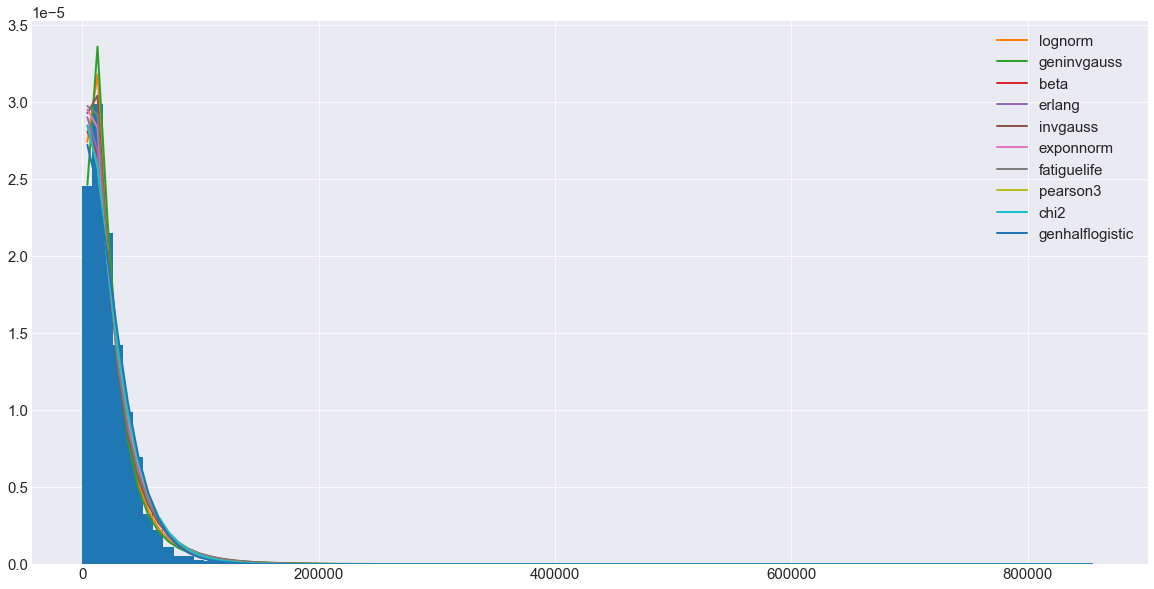

In [50]:
#Let's analyze what Distribution fits better with Revenue
fitter_norm = Fitter(data_small['Revenue'], distributions=stats)
fitter_norm.fit()
fitter_norm.summary(Nbest=10, plot=True)
fitter_norm.get_best(method='sumsquare_error')

,sumsquare_error,aic,bic,kl_div
burr12,0.036928,1282.717262,-25275.520096,inf
gengamma,0.048424,1452.675023,-24654.039674,inf
genlogistic,0.049086,1166.894543,-24630.655806,inf
johnsonsu,0.049183,1091.908553,-24618.408684,inf
loggamma,0.051255,1478.166938,-24531.516419,inf
powernorm,0.053807,1517.242742,-24420.109465,inf
johnsonsb,0.059600,1575.373658,-24177.905147,inf
exponweib,0.068584,1548.409773,-23855.958886,inf
pearson3,0.070857,1687.046627,-23788.917109,inf
beta,0.073096,1665.792612,-23709.862413,inf


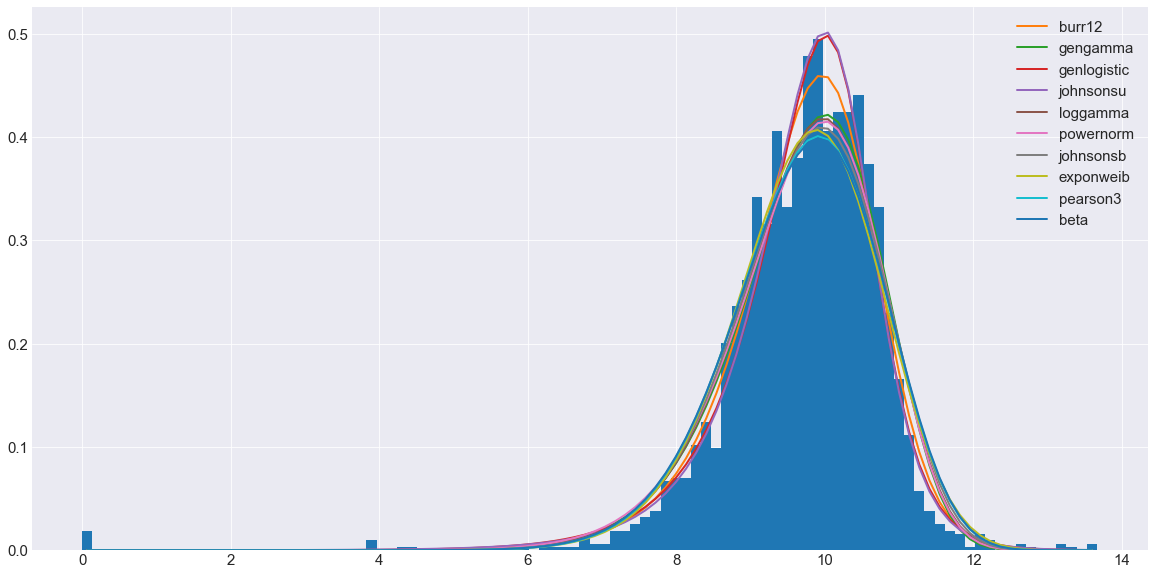

In [41]:
#Let's analyze what Distribution fits better with Revenue after a logarithmic transformation
fitter_log = Fitter(np.log1p(data_small['Revenue']), distributions=stats)
fitter_log.fit()
fitter_log.summary(Nbest=10, plot=True)
fitter_log.get_best(method='sumsquare_error')

/home/dsc/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error,aic,bic,kl_div
norminvgauss,0.000007,2381.874828,-44929.295493,inf
invgamma,0.000007,2267.710491,-44934.851317,inf
betaprime,0.000007,2269.640814,-44926.874785,inf
johnsonsb,0.000007,2372.878995,-44893.139447,inf
fatiguelife,0.000007,2483.989779,-44851.046814,inf
genlogistic,0.000007,2316.157497,-44839.795466,inf
gamma,0.000008,2637.895009,-44679.914903,inf
pearson3,0.000008,2637.895209,-44679.912792,inf
chi2,0.000008,2637.894584,-44679.911836,inf
beta,0.000008,2632.894976,-44650.974480,inf


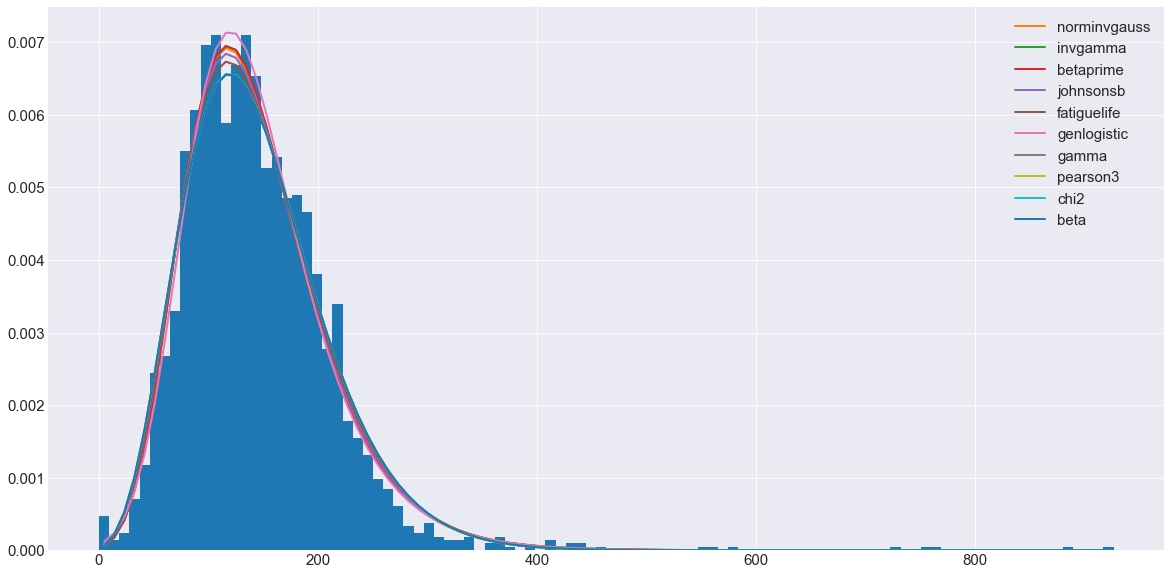

In [42]:
#Let's analyze what Distribution fits better with Revenue after a logarithmic transformation
fitter_sqr = Fitter(np.sqrt(data_small['Revenue']), distributions=stats)
fitter_sqr.fit()
fitter_sqr.summary(Nbest=10, plot=True)
fitter_sqr.get_best(method='sumsquare_error')

In [48]:
fitter.get_best(method='sumsquare_error')

{'norminvgauss': (12.950464878750978,
  10.848421324107541,
  -0.6789439577064692,
  94.51639112512959)}

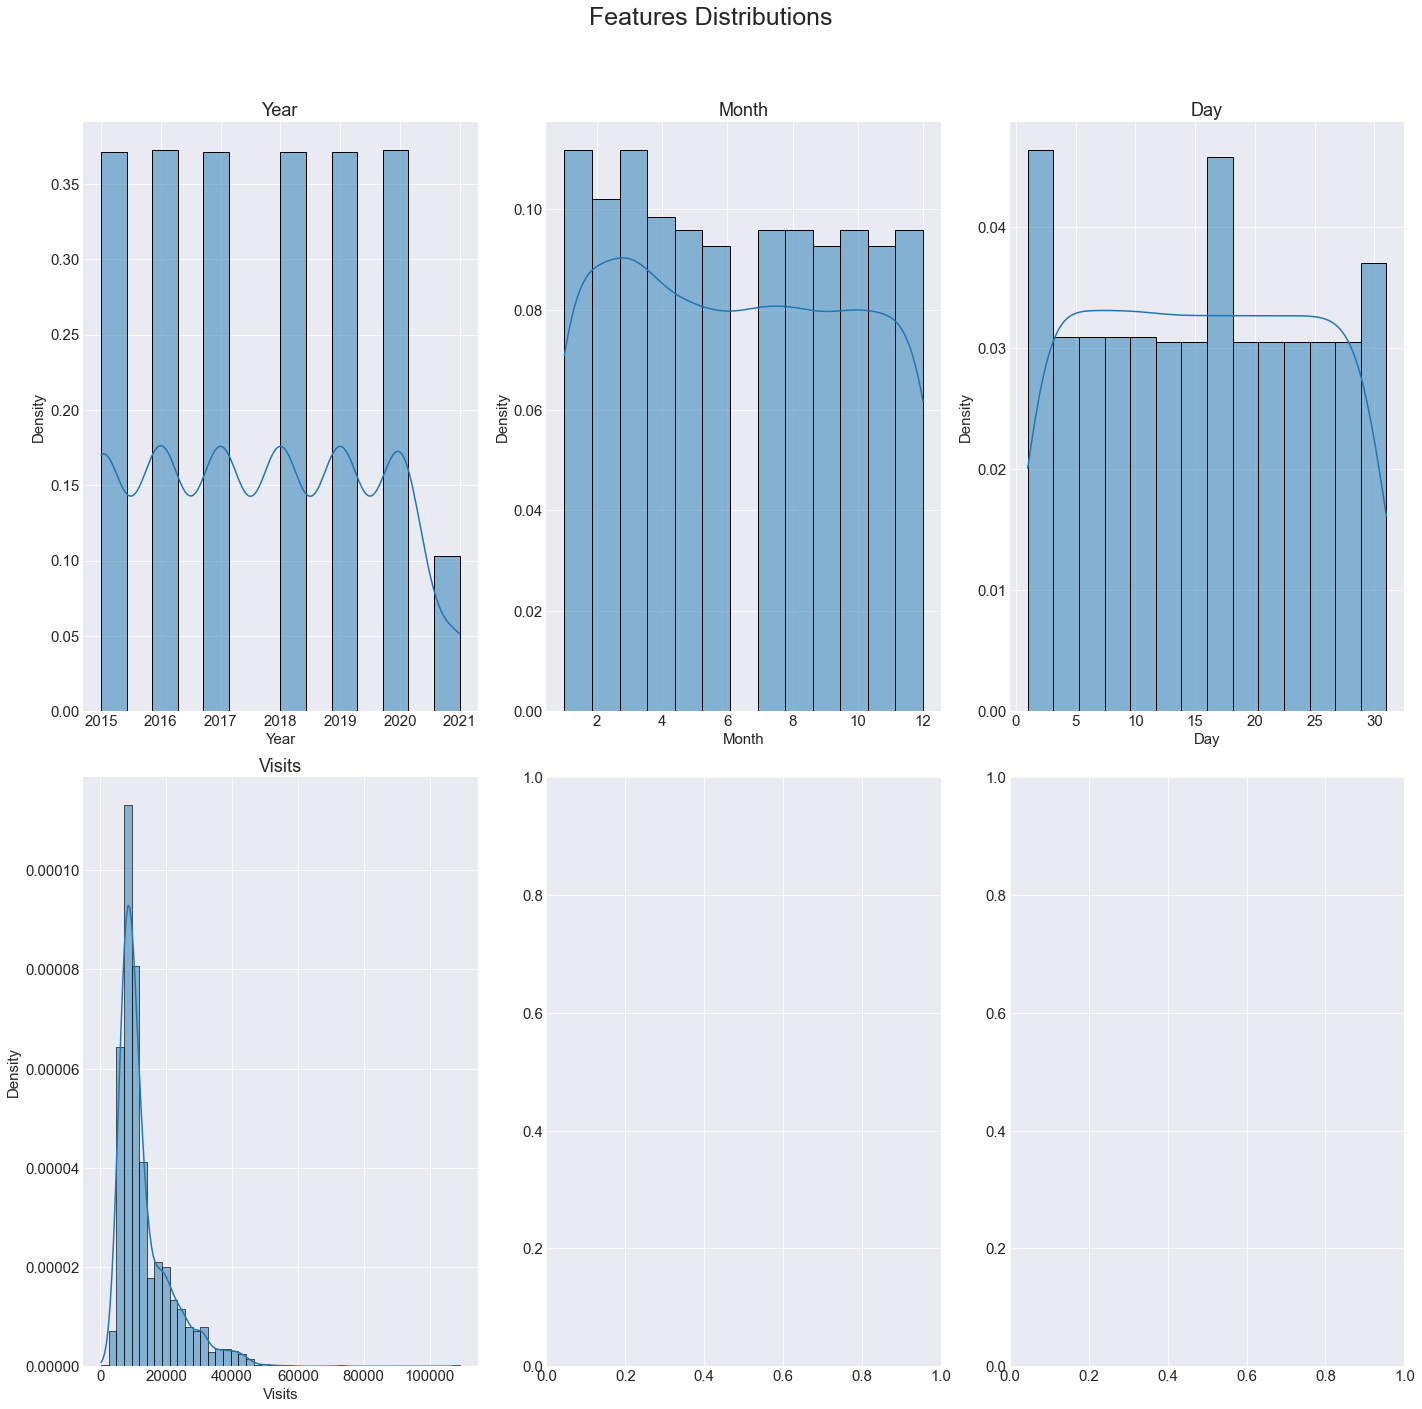

In [33]:
draw_distribution(data_small, data_small.columns[0:-1])

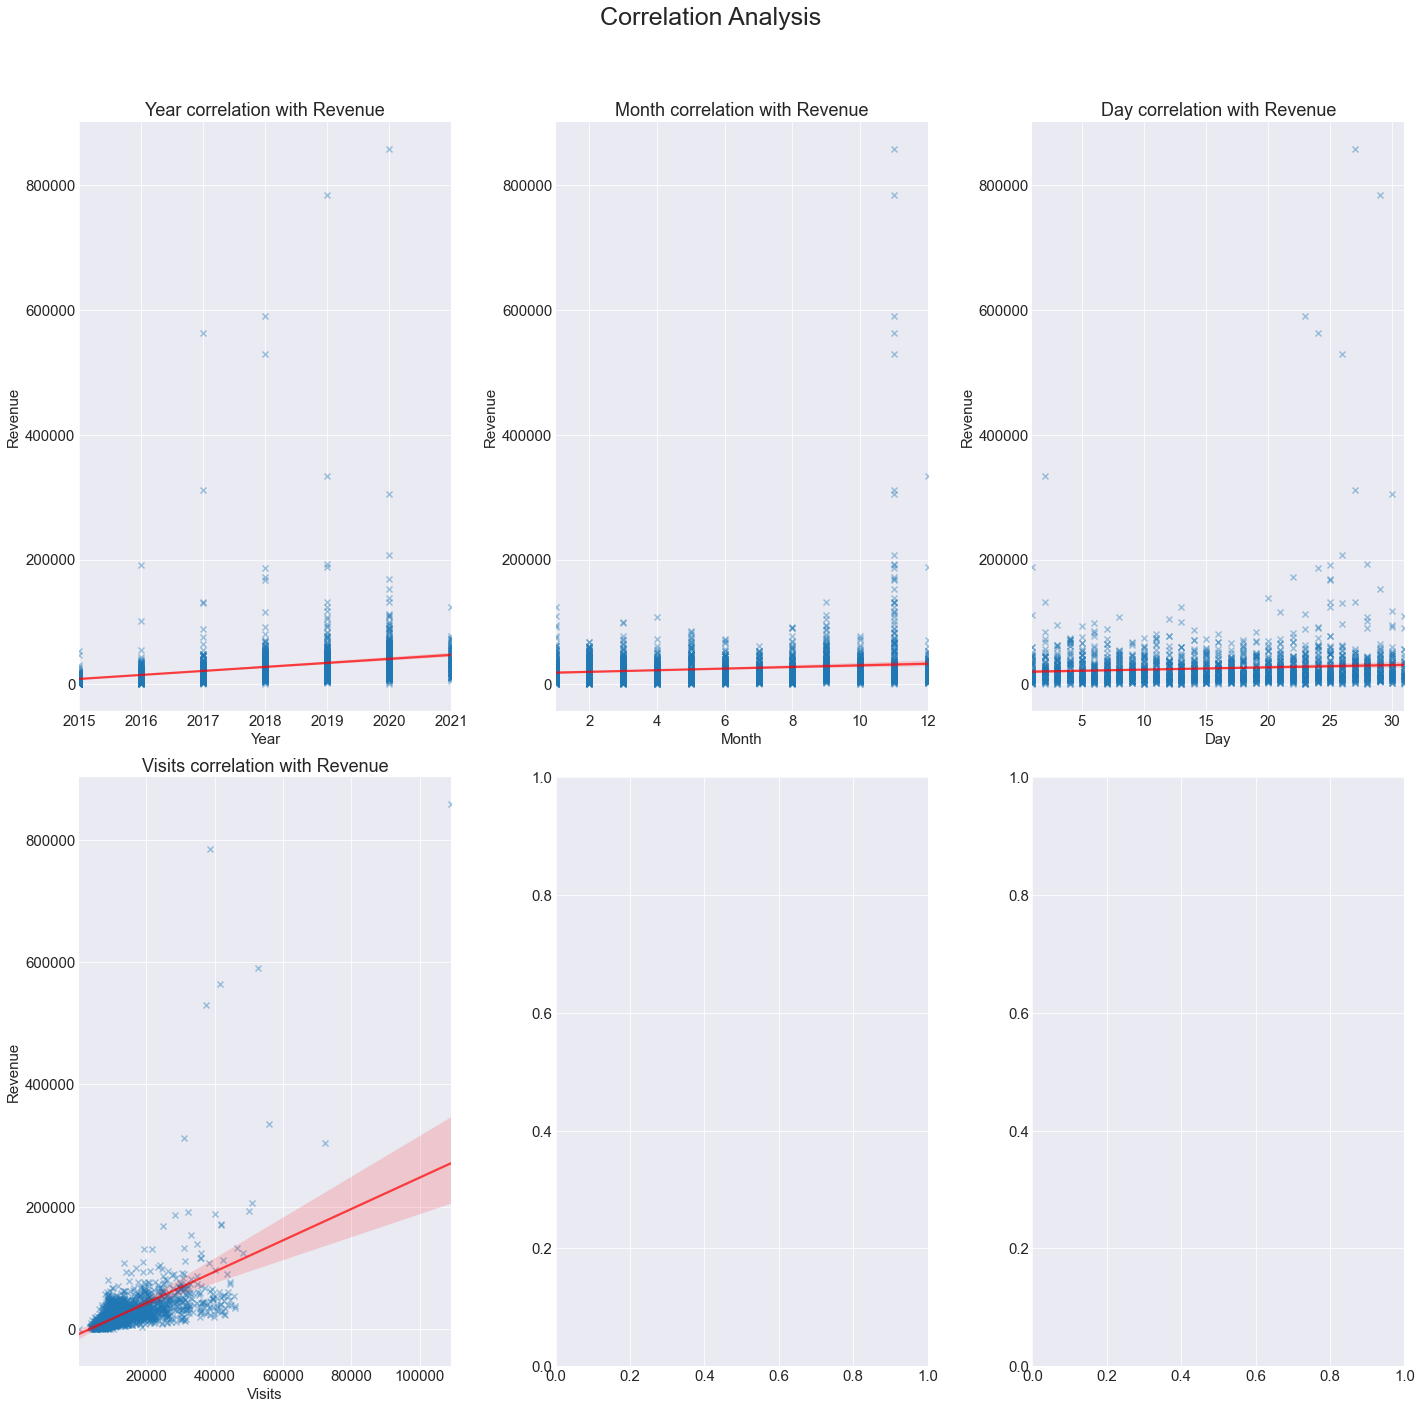

In [34]:
draw_correlation(data_small, data_small.columns[0:-1], data_small.columns[-1:])

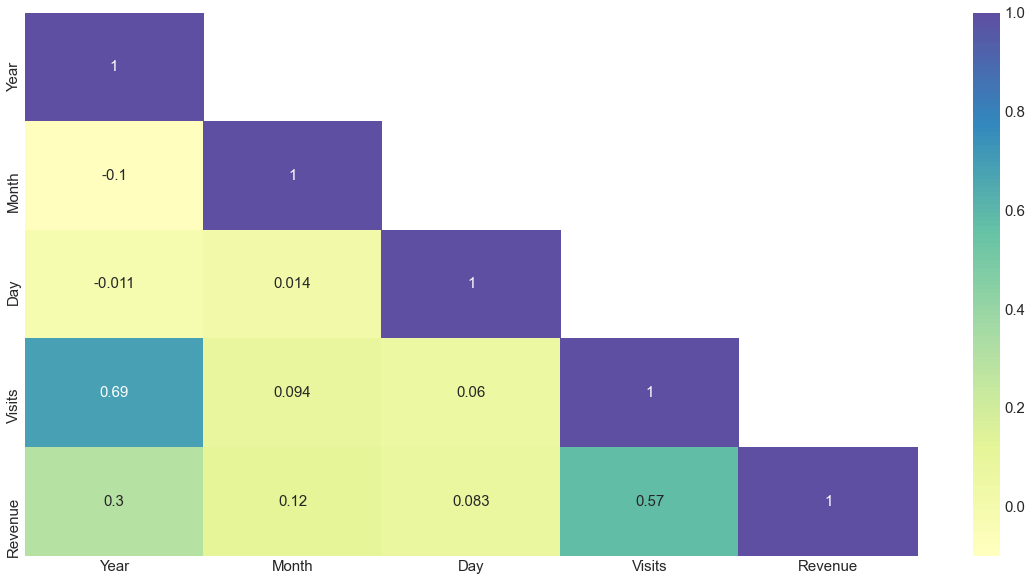

In [35]:
corr_matrix(data_small)

# Variance Analysis
It is important to see if we have features with variance close to 0 in that case, we should remove them. This only applies to quantitative variables.

In [36]:
np.std(data_small)

Year           1.817975
Month          3.492236
Day            8.805216
Visits      8630.435797
Revenue    38722.394213
dtype: float64

In [37]:
non_zero_variance(data_small, data_small.iloc[:,0:-1])

Year feature: has non-zero variance - Std:1.82
Month feature: has non-zero variance - Std:3.49
Day feature: has non-zero variance - Std:8.81
Visits feature: has non-zero variance - Std:8630.44


We would need to normalize because Year, Month and Day are quite small in comparison Visits

In [115]:
data_norm = data_normalization(data_small, 'norm')

In [116]:
data_norm

,Year,Month,Day,Visits,Revenue
0,-1.460196,-1.526906,-1.666984,-1.104854,-0.580674
1,-1.460196,-1.526906,-1.553415,-0.831983,-0.540721
2,-1.460196,-1.526906,-1.439846,-0.909151,-0.650649
3,-1.460196,-1.526906,-1.326277,-0.959786,-0.642553
4,-1.460196,-1.526906,-1.212707,-0.832446,-0.602652
...,...,...,...,...,...
2288,1.840178,-0.667857,-0.985569,1.521549,1.212743
2289,1.840178,-0.667857,-0.872000,1.277760,0.465173
2290,1.840178,-0.667857,-0.758431,1.167453,0.160004
2291,1.840178,-0.667857,-0.644862,0.190793,-0.069744


In [137]:
data_norm.columns[-1]

'Revenue'

KeyError: 'R'

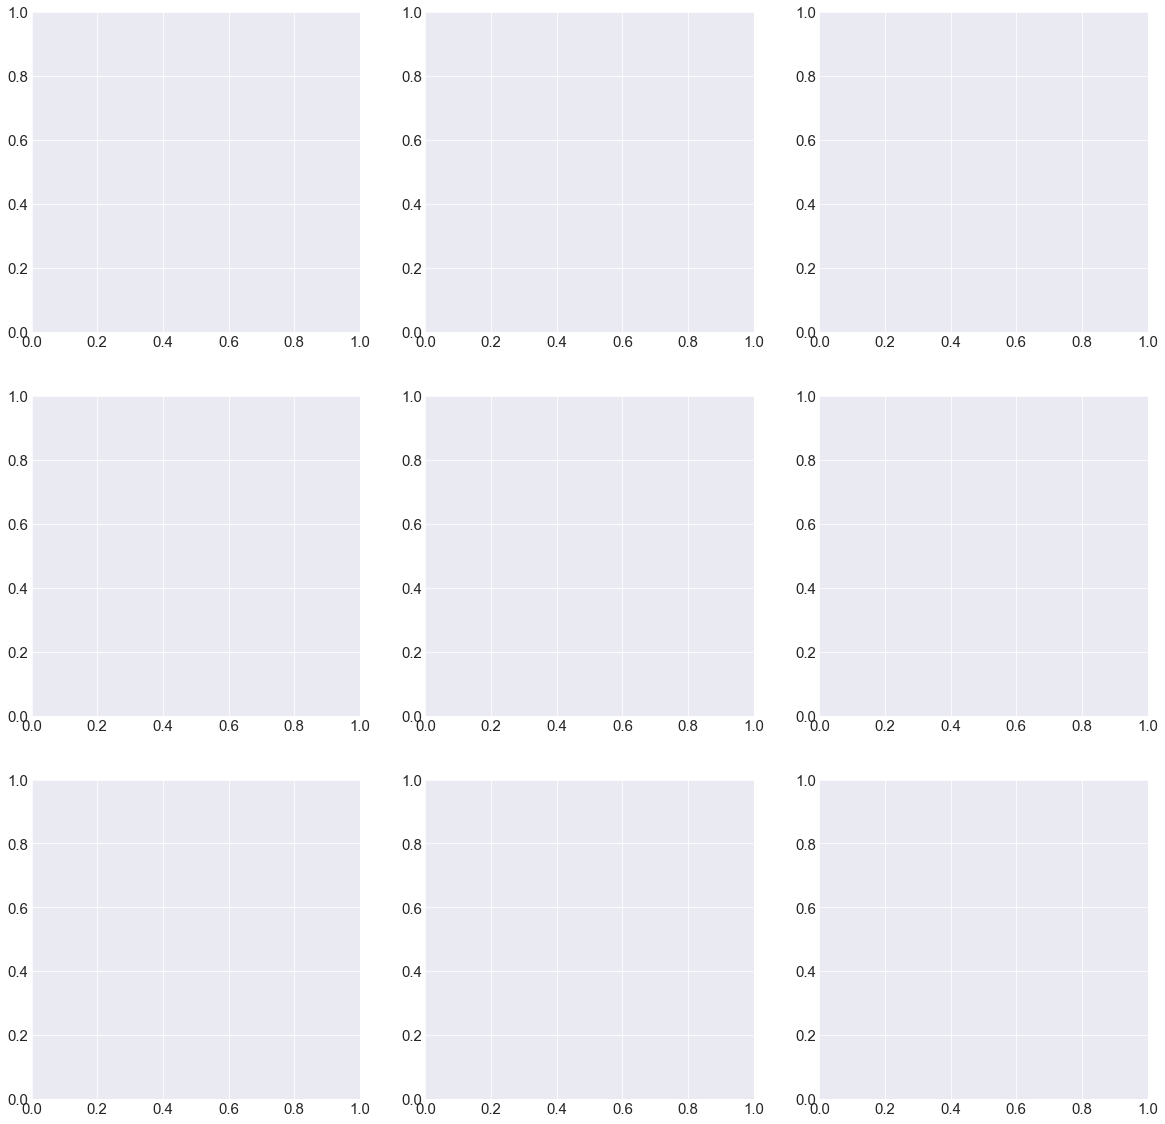

In [141]:
draw_distribution(data_norm, data_norm.columns[-1])

In [44]:
data_full = pd.concat([data_big, data_predict], ignore_index = True)

In [45]:
data_big_norm = data_normalization(data_big, 'norm')
data_big_norm

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,-1.455566,-1.623756,-0.136505,-0.136505,-0.732722,-1.669129,-1.614310,-0.629234,-1.144895,-0.663275,-0.969425
1,-1.455566,-1.558415,-0.136505,-0.136505,-0.518005,0.775805,-1.002738,-0.627239,-1.048583,-0.663275,-0.923885
2,-1.455566,-1.493075,-0.136505,-0.136505,-0.593110,0.177747,-0.851306,-0.629053,0.599694,-0.663275,-0.807590
3,-1.455566,-1.427734,-0.136505,-0.136505,-0.507139,0.136646,-0.904801,-0.630322,-0.974896,-0.663275,-0.732472
4,-1.455566,-1.362393,-0.136505,-0.136505,-0.541359,-0.051952,-0.949325,-0.626332,-1.071207,-0.663275,-0.863551
...,...,...,...,...,...,...,...,...,...,...,...
323,1.840814,-1.035690,-0.136505,-0.136505,2.298016,-0.613329,0.284600,1.046662,0.125249,1.737207,0.250300
324,1.840814,-0.970349,-0.136505,-0.136505,2.822155,-0.619627,-0.046000,0.345183,-0.156575,2.059802,0.353876
325,1.840814,-0.905008,-0.136505,-0.136505,3.896398,-0.653325,-0.241462,0.348448,-0.246422,1.948376,0.104877
326,1.840814,-0.839668,-0.136505,-0.136505,2.362704,-1.139240,-0.438653,-0.114369,0.021181,0.572605,-0.217621


In [46]:
data_big_norm['Black_Friday'] = data_big_norm['Black_Friday'].apply(lambda x: 0 if x < 0 else 1)
data_big_norm['Cyber_Monday'] = data_big_norm['Cyber_Monday'].apply(lambda x: 0 if x < 0 else 1)

In [47]:
data_big_norm['Black_Friday'].unique()

array([0, 1])

In [48]:
data_big_norm['Cyber_Monday'].unique()

array([0, 1])

In [49]:
data_big_norm

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,-1.455566,-1.623756,0,0,-0.732722,-1.669129,-1.614310,-0.629234,-1.144895,-0.663275,-0.969425
1,-1.455566,-1.558415,0,0,-0.518005,0.775805,-1.002738,-0.627239,-1.048583,-0.663275,-0.923885
2,-1.455566,-1.493075,0,0,-0.593110,0.177747,-0.851306,-0.629053,0.599694,-0.663275,-0.807590
3,-1.455566,-1.427734,0,0,-0.507139,0.136646,-0.904801,-0.630322,-0.974896,-0.663275,-0.732472
4,-1.455566,-1.362393,0,0,-0.541359,-0.051952,-0.949325,-0.626332,-1.071207,-0.663275,-0.863551
...,...,...,...,...,...,...,...,...,...,...,...
323,1.840814,-1.035690,0,0,2.298016,-0.613329,0.284600,1.046662,0.125249,1.737207,0.250300
324,1.840814,-0.970349,0,0,2.822155,-0.619627,-0.046000,0.345183,-0.156575,2.059802,0.353876
325,1.840814,-0.905008,0,0,3.896398,-0.653325,-0.241462,0.348448,-0.246422,1.948376,0.104877
326,1.840814,-0.839668,0,0,2.362704,-1.139240,-0.438653,-0.114369,0.021181,0.572605,-0.217621


In [50]:
data_predict_norm = data_normalization(data_predict, 'norm')

In [51]:
data_predict_norm['Black_Friday'] = data_predict_norm['Black_Friday'].apply(lambda x: 0 if x < 0 else 1)
data_predict_norm['Cyber_Monday'] = data_predict_norm['Cyber_Monday'].apply(lambda x: 0 if x < 0 else 1)

In [52]:
data_predict_norm['Black_Friday'].unique()

array([1])

In [53]:
data_predict_norm['Cyber_Monday'].unique()

array([1])

In [104]:
data_predict_norm

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,0.0,-1.341641,1,1,1.498453,0.460284,-0.883527,-0.728668,-1.718215,-1.478684,1.212571
1,0.0,-0.447214,1,1,0.304133,0.082287,0.845361,-1.151884,0.366760,1.041683,-1.513848
2,0.0,0.447214,1,1,-0.764387,1.076709,1.138015,1.372693,0.673505,0.781042,0.460923
3,0.0,1.341641,1,1,-1.038198,-1.619279,-1.099849,0.507859,0.677950,-0.344041,-0.159647


In [54]:
data_full_norm = pd.concat([data_big_norm, data_predict_norm], ignore_index = True)

In [55]:
data_full_norm

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,-1.455566,-1.623756,0,0,-0.732722,-1.669129,-1.614310,-0.629234,-1.144895,-0.663275,-0.969425
1,-1.455566,-1.558415,0,0,-0.518005,0.775805,-1.002738,-0.627239,-1.048583,-0.663275,-0.923885
2,-1.455566,-1.493075,0,0,-0.593110,0.177747,-0.851306,-0.629053,0.599694,-0.663275,-0.807590
3,-1.455566,-1.427734,0,0,-0.507139,0.136646,-0.904801,-0.630322,-0.974896,-0.663275,-0.732472
4,-1.455566,-1.362393,0,0,-0.541359,-0.051952,-0.949325,-0.626332,-1.071207,-0.663275,-0.863551
...,...,...,...,...,...,...,...,...,...,...,...
327,1.840814,-0.774327,0,0,2.182117,-0.922136,-0.172577,0.043047,-0.124255,-0.231607,0.434799
328,0.000000,-1.341641,1,1,1.498453,0.460284,-0.883527,-0.728668,-1.718215,-1.478684,1.212571
329,0.000000,-0.447214,1,1,0.304133,0.082287,0.845361,-1.151884,0.366760,1.041683,-1.513848
330,0.000000,0.447214,1,1,-0.764387,1.076709,1.138015,1.372693,0.673505,0.781042,0.460923


In [56]:
def corr(pred,y_test):
    return np.corrcoef(pred,y_test)[0][1]

def bias(pred,y_test):
    return np.mean(pred-y_test)

In [57]:
#X_params = data.columns[0:-1] #All columns except the last one - ['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display']
#y_params = data.columns[-1] #Just Revenue

#Train and Test for training
X_train, X_test, y_train, y_test = data_split(*data_preparation(data_big_norm))

#Full Set and Small Set for prediction
X_full, y_full = data_preparation(data_full_norm)
X_small, y_small = data_preparation(data_predict_norm)

In [58]:
LR = LinearRegression()
LR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(X_test)))
print('Test set score:', LR.score(X_test,y_test))

Train set mse: 0.13636104782359923
Test set mse: 0.1531745804527542
Test set score: 0.8967521136456784


<AxesSubplot:>

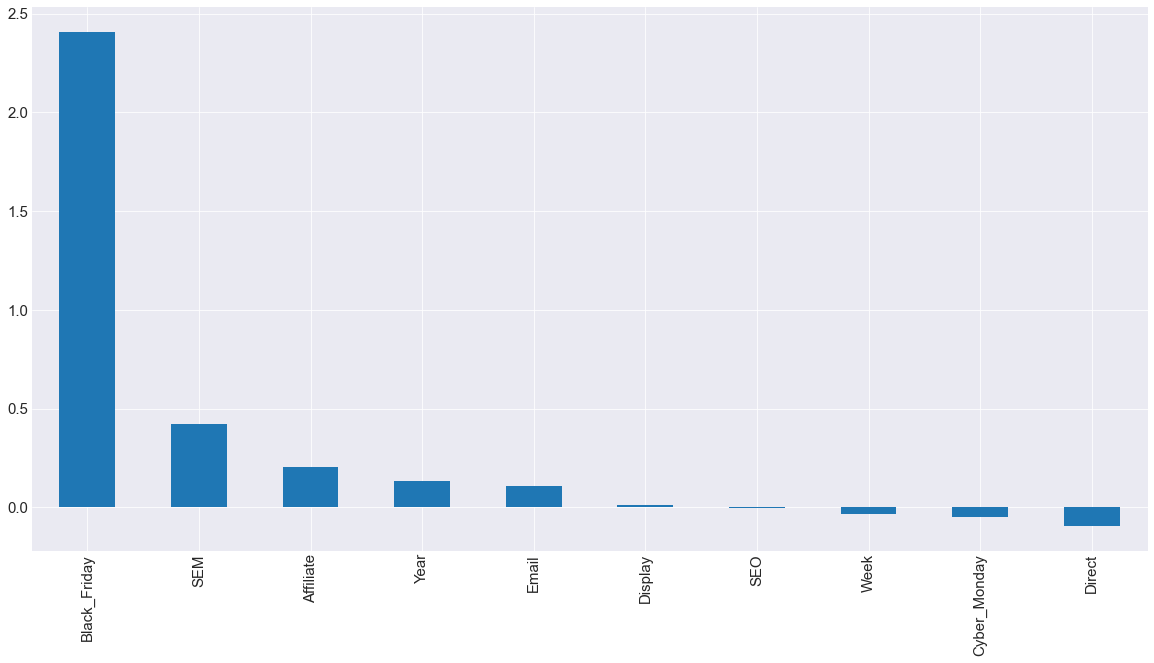

In [59]:
#Features Importance
pd.Series(LR.coef_, data_big.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

(array([1., 0., 0., 0., 0., 0., 1., 1., 0., 2.]),
 array([-0.18700208, -0.16148441, -0.13596673, -0.11044906, -0.08493139,
        -0.05941372, -0.03389605, -0.00837838,  0.01713929,  0.04265696,
         0.06817463]),
 <BarContainer object of 10 artists>)

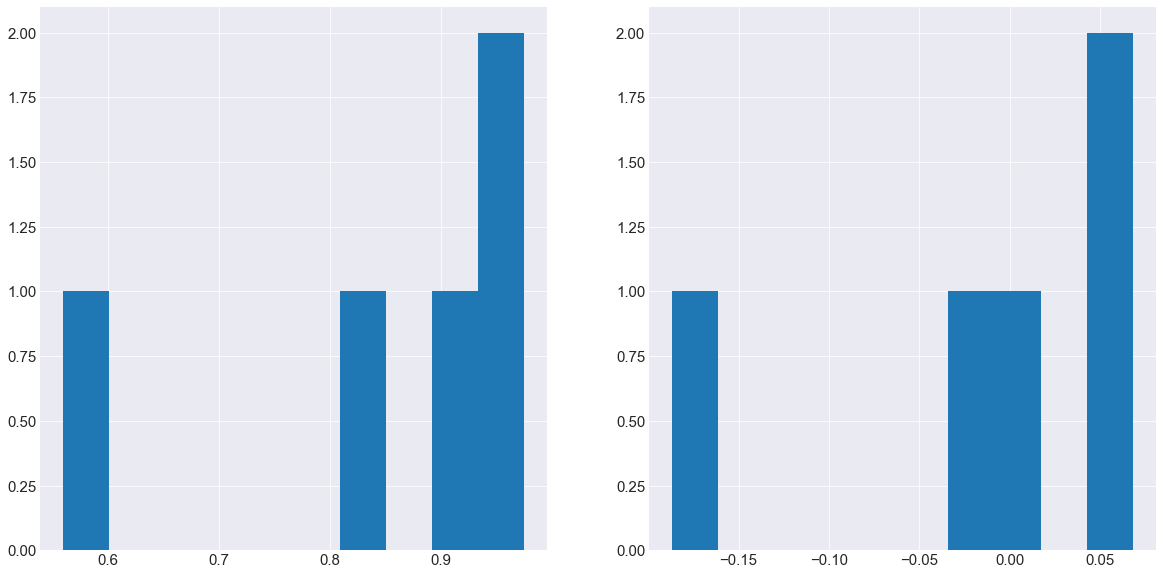

In [78]:
variance = cross_val_score(LR,X_train,y_train,cv=5,scoring=make_scorer(corr))
biass = cross_val_score(LR,X_train,y_train,cv=5,scoring=make_scorer(bias))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,10)
ax[0].hist( variance)
ax[1].hist(biass)

In [61]:
RFR = RandomForestRegressor(n_estimators = 100, criterion = 'mae', bootstrap = False)
RFR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(X_test)))
print('Test set score:', RFR.score(X_test,y_test))

Train set mse: 1.5332762075191252e-30
Test set mse: 0.15224818254582925
Test set score: 0.8973765555441342


In [62]:
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(X_test)))
print('Test set score:', XGB.score(X_test,y_test))

Train set mse: 3.850313966188338e-07
Test set mse: 0.09976540545599114
Test set score: 0.9327527634535279


In [63]:
LGBM = LGBMRegressor(max_depth=16,num_leaves=2048, n_estimators=200,seed=1)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)

print('Train set mse:', mean_squared_error(y_train, LGBM.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LGBM.predict(X_test)))
print('Test set score:', LGBM.score(X_test,y_test))

Train set mse: 0.07075930859104052
Test set mse: 0.5216604940214512
Test set score: 0.6483728354726657


LinearRegression | Predict MAE: 2.3145
LinearRegression | Predict RMSE: 2.6720
LinearRegression | Predict R2: -6.1397
RandomForestRegressor | Predict MAE: 0.8783
RandomForestRegressor | Predict RMSE: 1.1154
RandomForestRegressor | Predict R2: -0.2442
XGBRegressor | Predict MAE: 0.9625
XGBRegressor | Predict RMSE: 1.0887
XGBRegressor | Predict R2: -0.1853
LGBMRegressor | Predict MAE: 1.3735
LGBMRegressor | Predict RMSE: 1.5725
LGBMRegressor | Predict R2: -1.4726


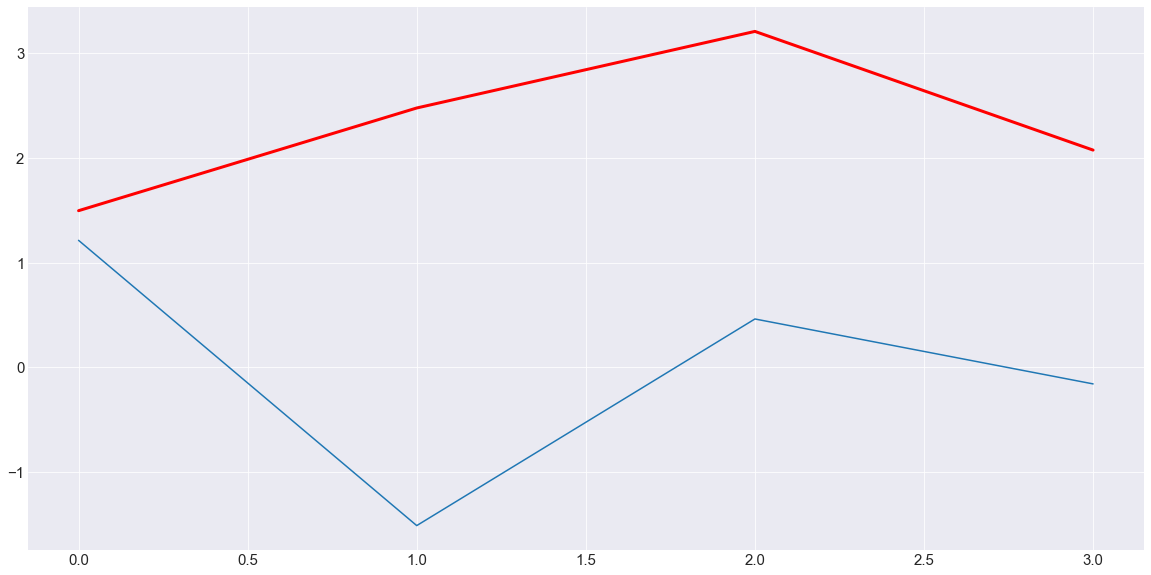

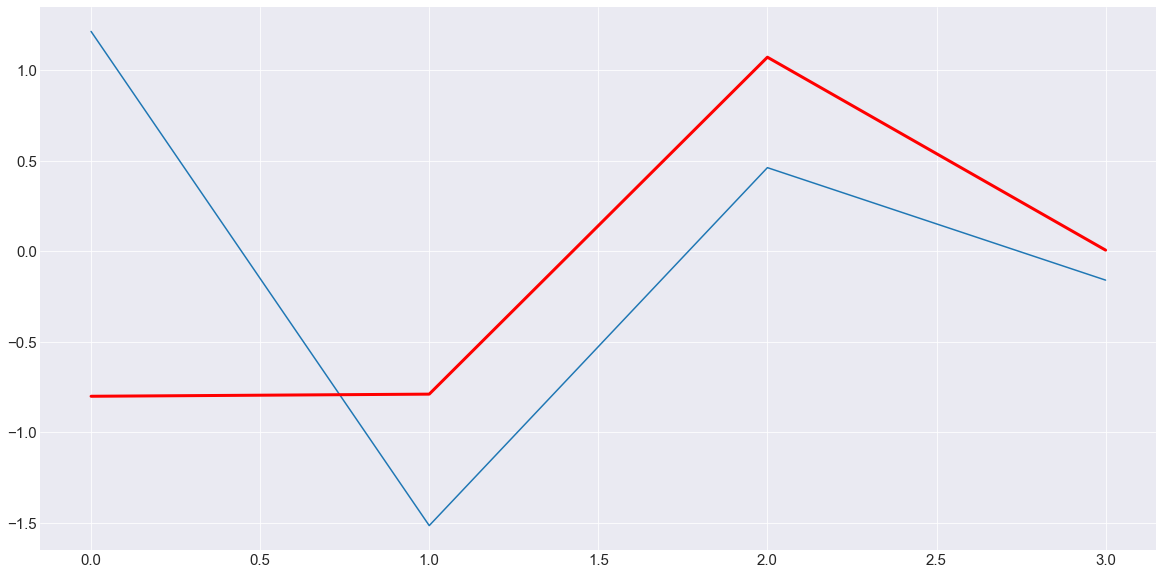

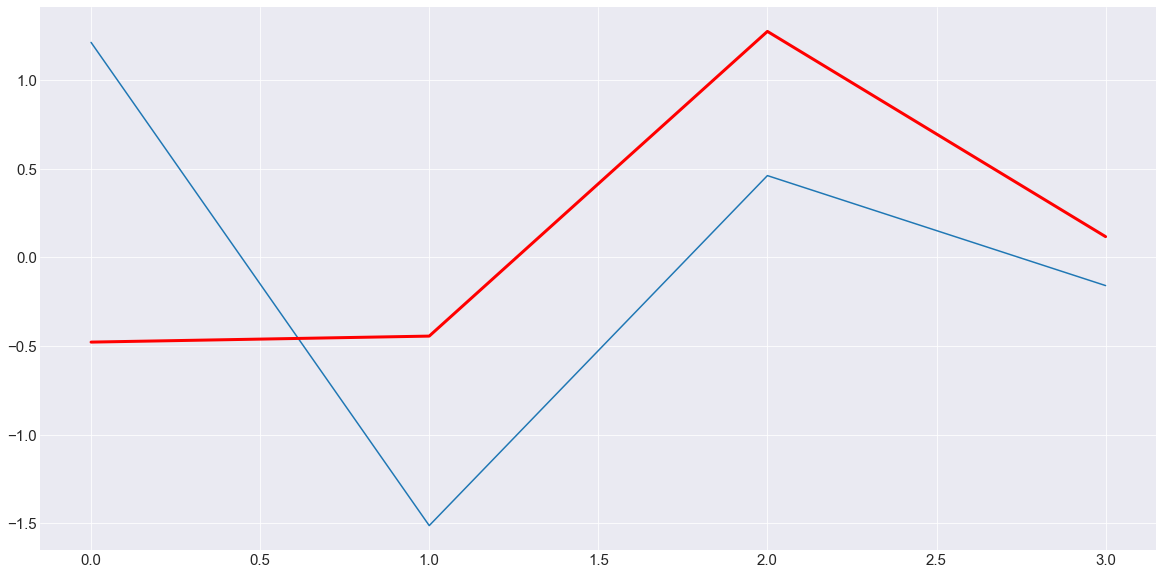

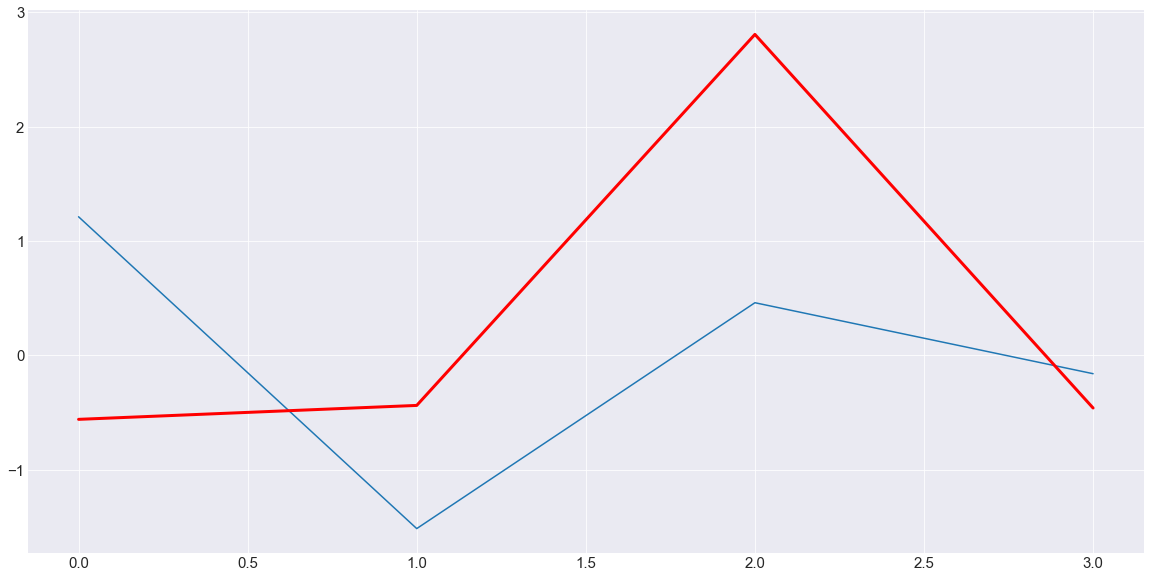

In [64]:
#model = [LR, RFR, XGB, LGBM]
model = [LR, RFR, XGB, LGBM]
for i in model:
    draw_predict(i, X_small, y_small)
    #draw_predict(i, X_full, y_full)

In [38]:
#Lets see the data. We are not going to work with all Programs
#Just SEO, Direct, SEM, Display, Affiliate and Email
#We are going to sum in the Display bucket Paid Social, Organic Social, Lenovo Social, Social
#And the rest will go to the Direct bucket
data.groupby(['Program'])['Visits'].sum().reset_index().sort_values('Visits', ascending=False)

,Program,Visits
14,SEO,10123792
5,Direct,9447233
13,SEM,6433696
6,Display,1754140
1,Affiliate,1145913
11,Paid Social,840522
7,Email,615732
9,Organic Social,108568
4,Company Social,71203
2,Apps,67551


In [417]:
#Let's grouped by Week and expand the Program Features but also this is going to be a subset
#Additionally, we have add to Categorical Variables which explain when Black Friday and Cyber Monday takes placed
data_big = dataframe_preparation(data)
data_big.head(10)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2015,1,0,0,4744,15758,0,24,106,0,9419.550
1,2015,2,0,0,11897,37887,7431,35,255,0,17426.790
2,2015,3,0,0,9395,32474,9271,25,2805,0,37874.740
3,2015,4,0,0,12259,32102,8621,18,369,0,51082.540
4,2015,5,0,0,11119,30395,8080,40,220,0,28035.240
5,2015,6,0,0,10037,27749,7367,18,1087,62,47267.600
6,2015,7,0,0,10552,24753,8867,18,1355,59,27090.700
7,2015,8,0,0,9970,26377,8568,12,173,74,35141.470
8,2015,9,0,0,9476,27482,7849,14,108,93,33240.480
9,2015,10,0,0,10750,29514,10458,17,1465,521,47631.545


In [40]:
data_predict = dataframe_preparation(data_predict)
data_predict.head(10)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2021,15,0,0,101202,23086,21137,3261,1658,12494,277288.61
1,2021,16,0,0,68401,22761,27275,3146,2127,22512,157303.90
2,2021,17,0,0,39055,23616,28314,3832,2196,21476,244209.96
3,2021,18,0,0,31535,21298,20369,3597,2197,17004,216899.81


In [43]:
data_full = pd.concat([data_big, data_predict], ignore_index = True)
data_full.head(10)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2015,1,0,0,4744,15758,0,24,106,0,9419.55
1,2015,2,0,0,11897,37887,7431,35,255,0,17426.79
2,2015,3,0,0,9395,32474,9271,25,2805,0,37874.74
3,2015,4,0,0,12259,32102,8621,18,369,0,51082.54
4,2015,5,0,0,11119,30395,8080,40,220,0,28035.24
5,2015,6,0,0,10037,27749,7367,18,1087,62,47267.60
6,2015,7,0,0,10552,24753,8867,18,1355,59,27090.70
7,2015,8,0,0,9970,26377,8568,12,173,74,35141.47
8,2015,9,0,0,9476,27482,7849,14,108,93,33240.48
9,2015,10,0,0,10750,29514,10458,17,1465,521,41893.22


LinearRegression | Predict MAE: 55498.1839
LinearRegression | Predict RMSE: 65743.6040
LinearRegression | Predict R2: -1.2317
RandomForestRegressor | Predict MAE: 44151.6723
RandomForestRegressor | Predict RMSE: 46977.3018
RandomForestRegressor | Predict R2: -0.1395
XGBRegressor | Predict MAE: 57583.6434
XGBRegressor | Predict RMSE: 69794.2914
XGBRegressor | Predict R2: -1.5152
LGBMRegressor | Predict MAE: 49326.6867
LGBMRegressor | Predict RMSE: 60300.0933
LGBMRegressor | Predict R2: -0.8775


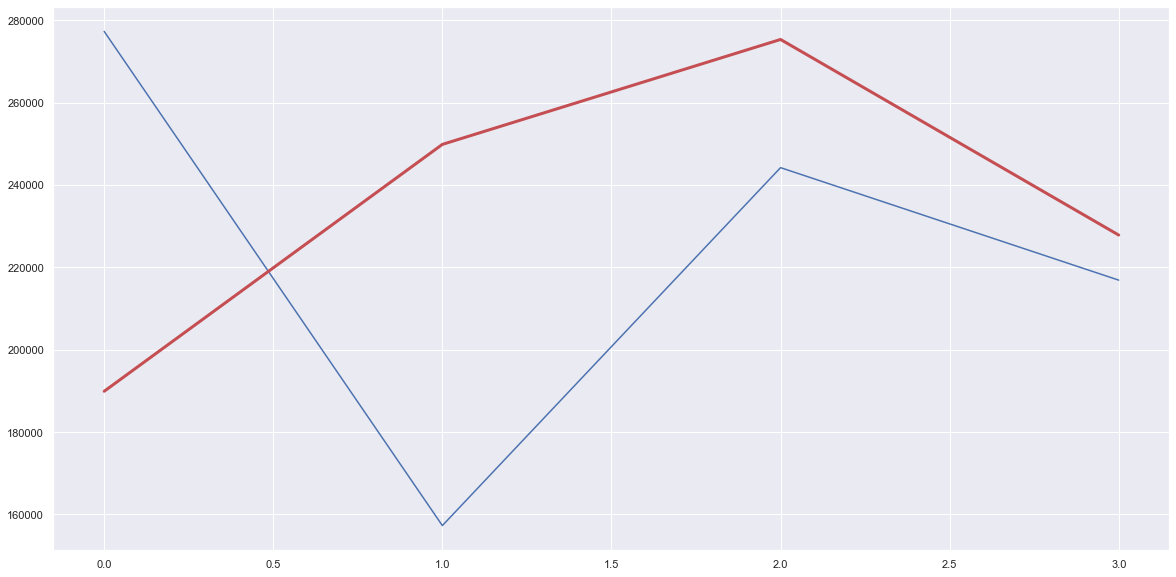

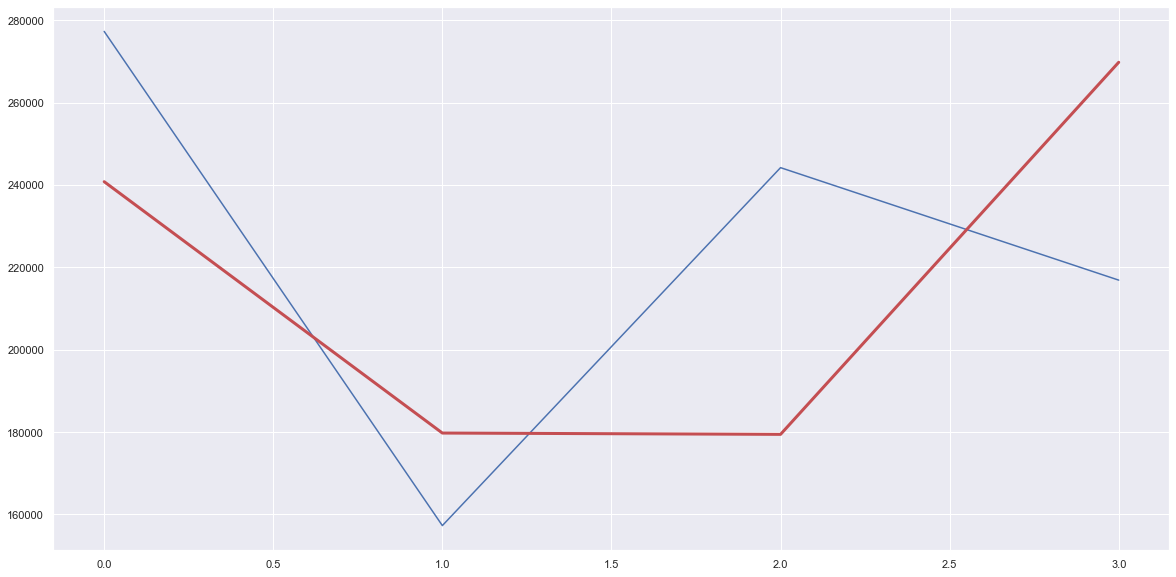

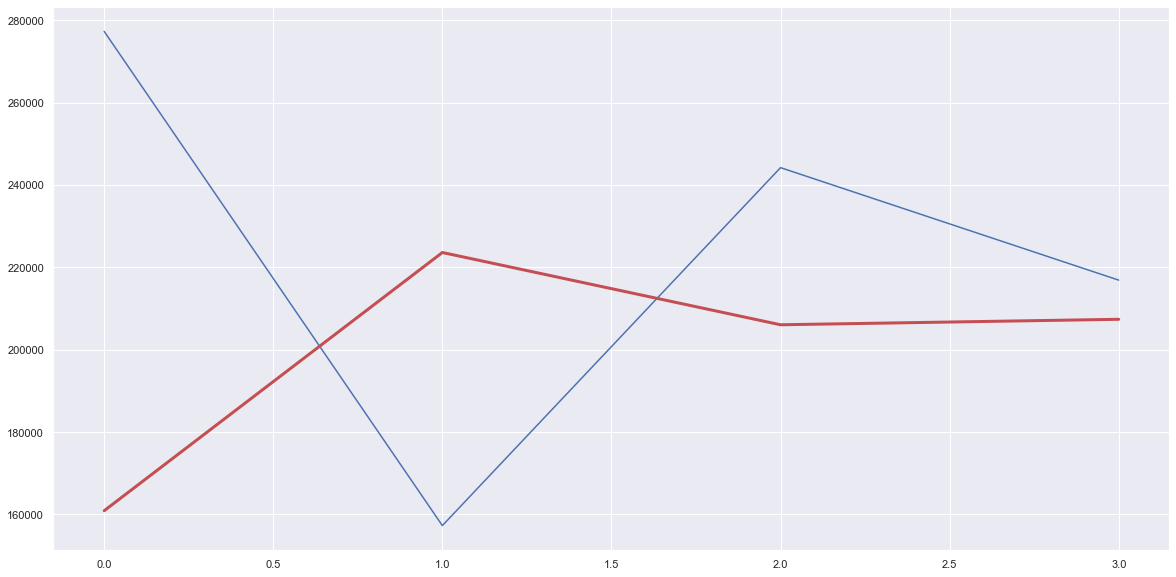

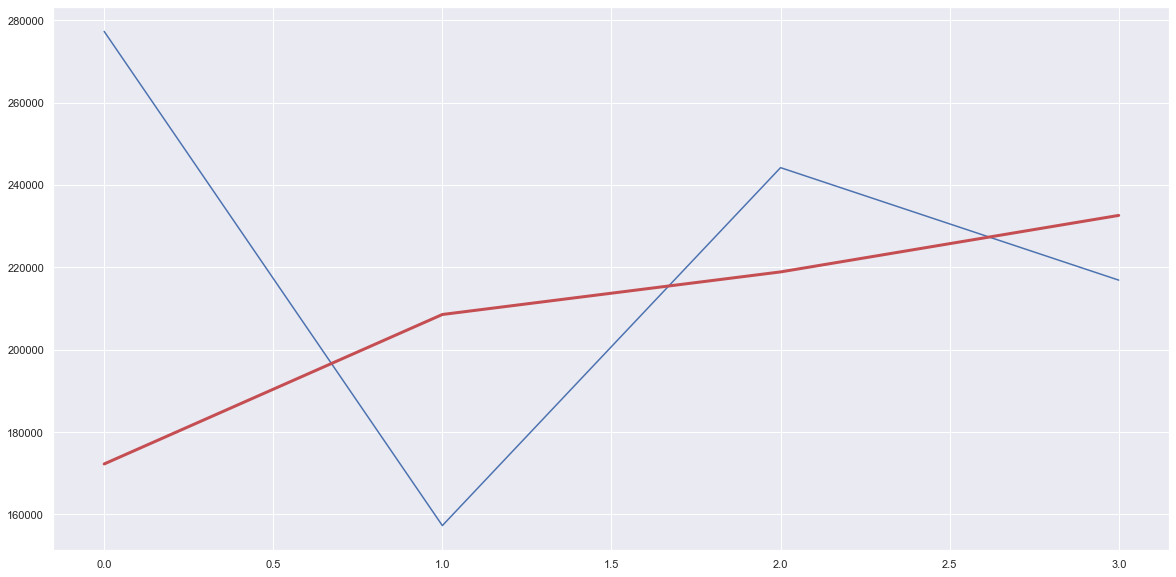

In [151]:
#model = [LR, RFR, XGB, LGBM]
model = [LR, RFR, XGB, LGBM]
for i in model:
    draw_predict(i, X_small, y_small)
    #draw_predict(i, X_full, y_full)

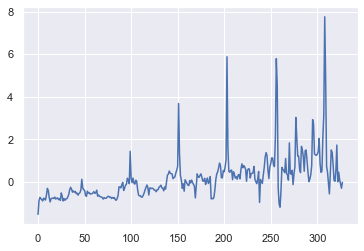

In [20]:
plt.plot(data_normalization(data, 'robust').index, data_normalization(data, 'robust')['SEM'])

(array([  1.,   1.,   0.,   1.,   3.,   5.,  21.,  30.,  72., 194.]),
 array([0.39565462, 0.45576129, 0.51586795, 0.57597462, 0.63608129,
        0.69618796, 0.75629462, 0.81640129, 0.87650796, 0.93661463,
        0.9967213 ]),
 <BarContainer object of 10 artists>)

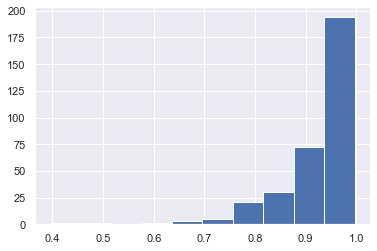

In [151]:
plt.hist(data_normalization(data, 'norm2')['Revenue'] )#bins=np.linspace(start=-2,stop=8,num=90)
#plt.plot(data_normalization(data, 'norm').index, data_normalization(data, 'norm')['SEM'])

In [66]:
data.apply(np.log1p)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,7.608871,0.693147,0.0,0.0,8.464847,9.665167,0.000000,3.218876,4.672829,0.000000,9.150649
1,7.608871,1.098612,0.0,0.0,9.384126,10.542390,8.913550,3.583519,5.545177,0.000000,9.765821
2,7.608871,1.386294,0.0,0.0,9.148039,10.388226,9.134754,3.258097,7.939515,0.000000,10.542066
3,7.608871,1.609438,0.0,0.0,9.414097,10.376705,9.062072,2.944439,5.913503,0.000000,10.841218
4,7.608871,1.791759,0.0,0.0,9.316501,10.322066,8.997271,3.713572,5.398163,0.000000,10.241253
...,...,...,...,...,...,...,...,...,...,...,...
323,7.611842,2.397895,0.0,0.0,11.568455,10.139152,10.046462,9.134107,7.636270,10.329213,12.318878
324,7.611842,2.484907,0.0,0.0,11.721329,10.136898,9.855190,8.593784,7.400010,10.455302,12.397084
325,7.611842,2.564949,0.0,0.0,11.976395,10.124749,9.722086,8.597113,7.311218,10.413523,12.197604
326,7.611842,2.639057,0.0,0.0,11.588636,9.930859,9.567035,7.959975,7.555382,9.665357,11.860825


In [64]:
data_normalization(data)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,-1.455566,-1.623756,-0.136505,-0.136505,-0.732722,-1.669129,-1.614310,-0.629234,-1.144895,-0.663275,-0.969425
1,-1.455566,-1.558415,-0.136505,-0.136505,-0.518005,0.775805,-1.002738,-0.627239,-1.048583,-0.663275,-0.923885
2,-1.455566,-1.493075,-0.136505,-0.136505,-0.593110,0.177747,-0.851306,-0.629053,0.599694,-0.663275,-0.807590
3,-1.455566,-1.427734,-0.136505,-0.136505,-0.507139,0.136646,-0.904801,-0.630322,-0.974896,-0.663275,-0.732472
4,-1.455566,-1.362393,-0.136505,-0.136505,-0.541359,-0.051952,-0.949325,-0.626332,-1.071207,-0.663275,-0.863551
...,...,...,...,...,...,...,...,...,...,...,...
323,1.840814,-1.035690,-0.136505,-0.136505,2.298016,-0.613329,0.284600,1.046662,0.125249,1.737207,0.250300
324,1.840814,-0.970349,-0.136505,-0.136505,2.822155,-0.619627,-0.046000,0.345183,-0.156575,2.059802,0.353876
325,1.840814,-0.905008,-0.136505,-0.136505,3.896398,-0.653325,-0.241462,0.348448,-0.246422,1.948376,0.104877
326,1.840814,-0.839668,-0.136505,-0.136505,2.362704,-1.139240,-0.438653,-0.114369,0.021181,0.572605,-0.217621


In [13]:
data.describe()

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,3.280000e+02
mean,2017.649390,25.850610,0.018293,0.018293,29153.661585,30865.219512,19614.926829,3493.637195,1877.231707,8458.652439,1.798721e+05
std,1.822959,15.327783,0.134212,0.134212,33364.571361,9064.790858,12169.224540,5522.490739,1549.433410,12772.337295,1.760972e+05
min,2015.000000,1.000000,0.000000,0.000000,4744.000000,12200.000000,0.000000,5.000000,80.000000,0.000000,9.419550e+03
25%,2016.000000,12.000000,0.000000,0.000000,10159.750000,25354.500000,11729.750000,685.000000,949.500000,415.500000,8.729839e+04
50%,2018.000000,25.500000,0.000000,0.000000,12257.500000,29937.000000,17840.500000,1605.500000,1468.500000,2795.000000,1.465062e+05
75%,2019.000000,39.000000,0.000000,0.000000,43434.250000,35060.250000,23354.000000,4160.500000,2347.250000,12024.000000,2.255418e+05
max,2021.000000,53.000000,1.000000,1.000000,183505.000000,83666.000000,107992.000000,58734.000000,12566.000000,72378.000000,1.698646e+06


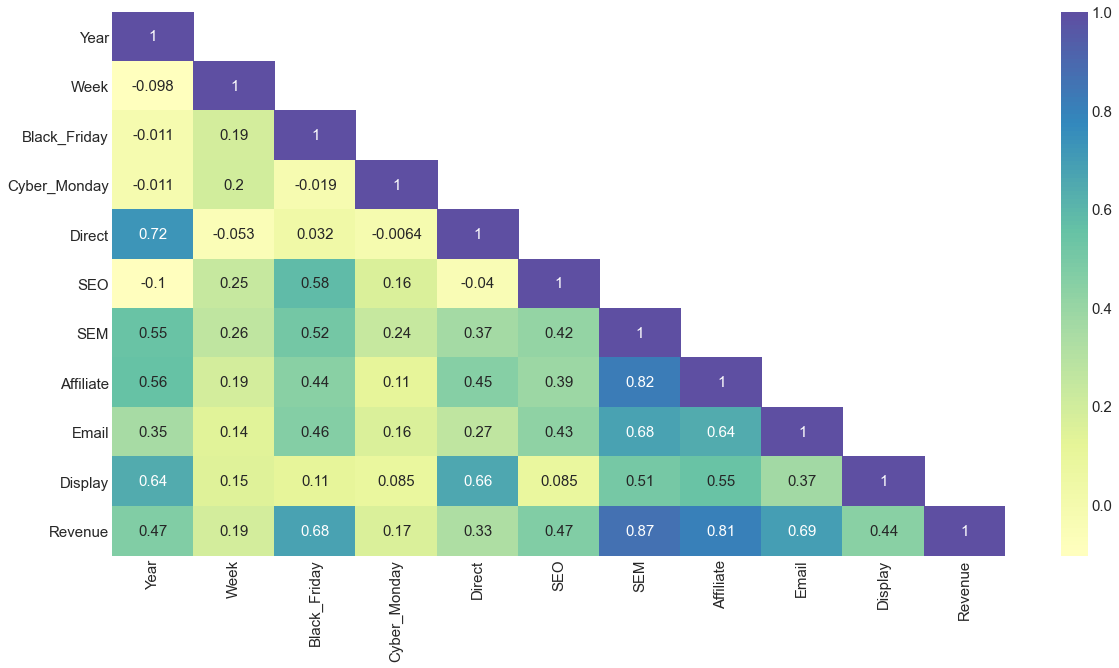

In [46]:
corr_matrix(data_big)

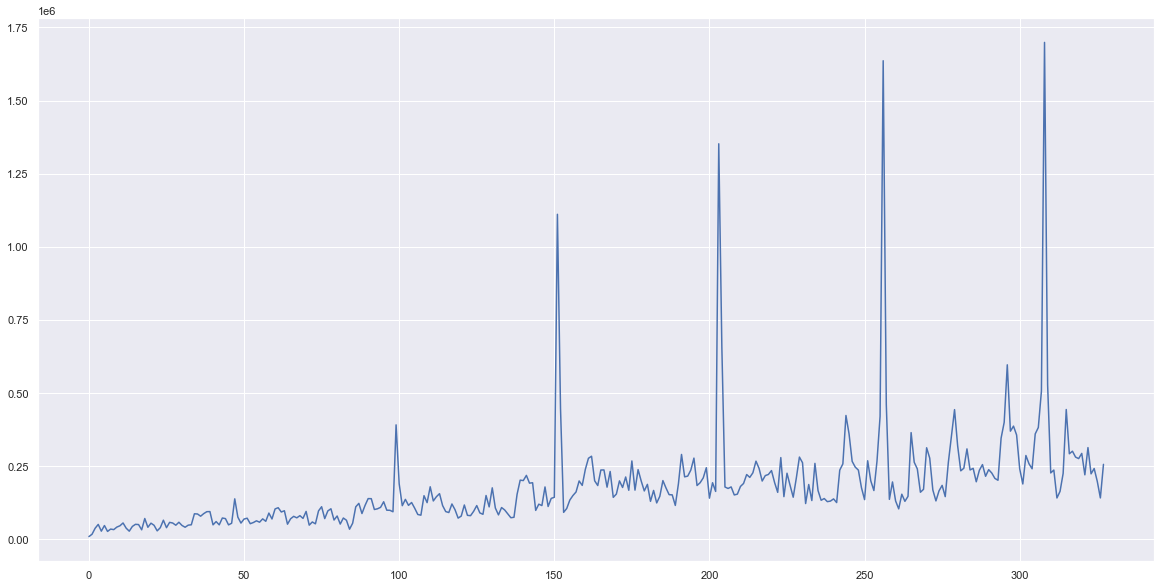

In [15]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(data.index, data['Revenue'])

In [60]:
#X_params = data.columns[0:-1] #All columns except the last one - ['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display']
#y_params = data.columns[-1] #Just Revenue

#Train and Test for training
X_train, X_test, y_train, y_test = data_split(*data_preparation(data_big))

#Full Set and Small Set for prediction
X_full, y_full = data_preparation(data_full)
X_small, y_small = data_preparation(data_predict)

In [ ]:
#Ridge : Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.
#Lasso : The Lasso is a linear model that estimates sparse coefficients with l1 regularization.
#ElasticNet : Elastic-Net is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [71]:
def corr(pred,y_test):
    return np.corrcoef(pred,y_test)[0][1]

def bias(pred,y_test):
    return np.mean(pred-y_test)

In [62]:
LR = LinearRegression()
LR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(X_test)))
print('Test set score:', LR.score(X_test,y_test))

Train set mse: 4215695243.864121
Test set mse: 4735497127.684606
Test set score: 0.896752113645494


<AxesSubplot:>

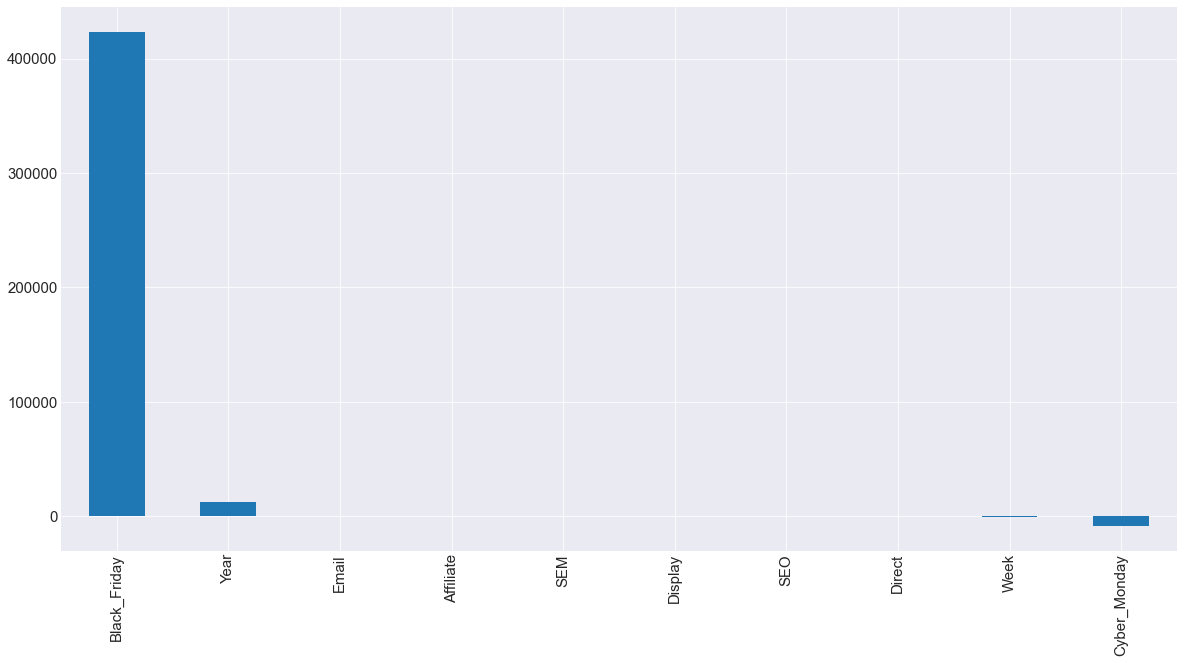

In [64]:
#Features Importance
pd.Series(LR.coef_, data_big.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:>

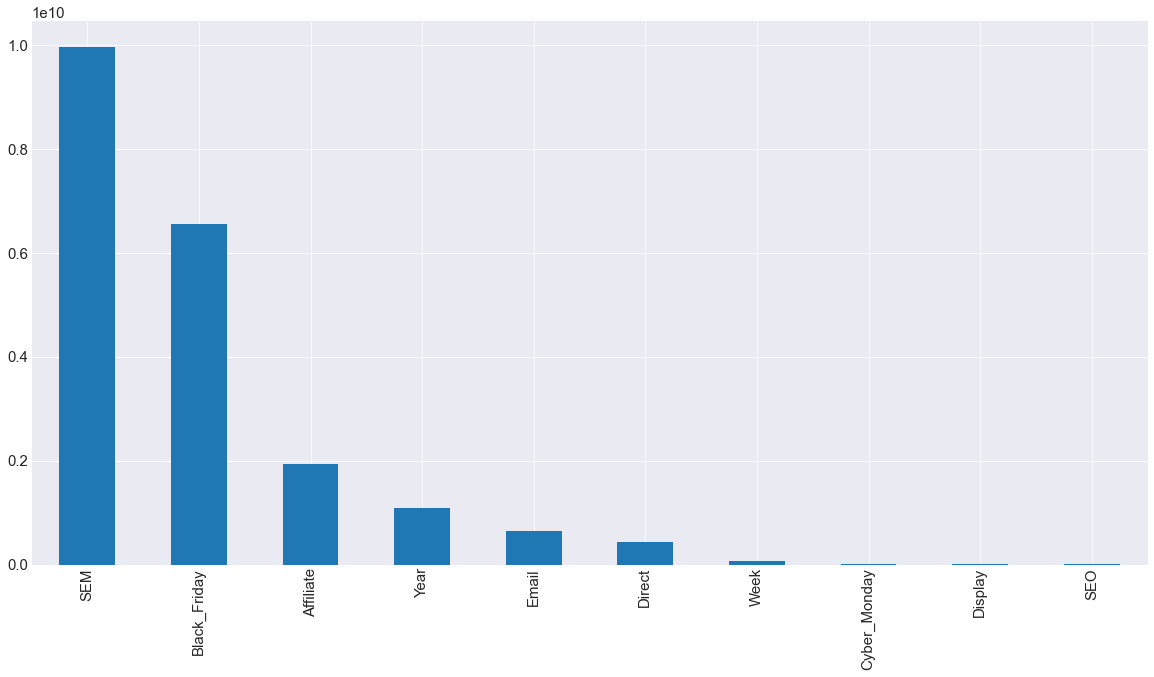

In [65]:
#Permutation Features Importance
results = permutation_importance(LR, X_train, y_train, n_repeats=100, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
pd.Series(importance, data_big.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

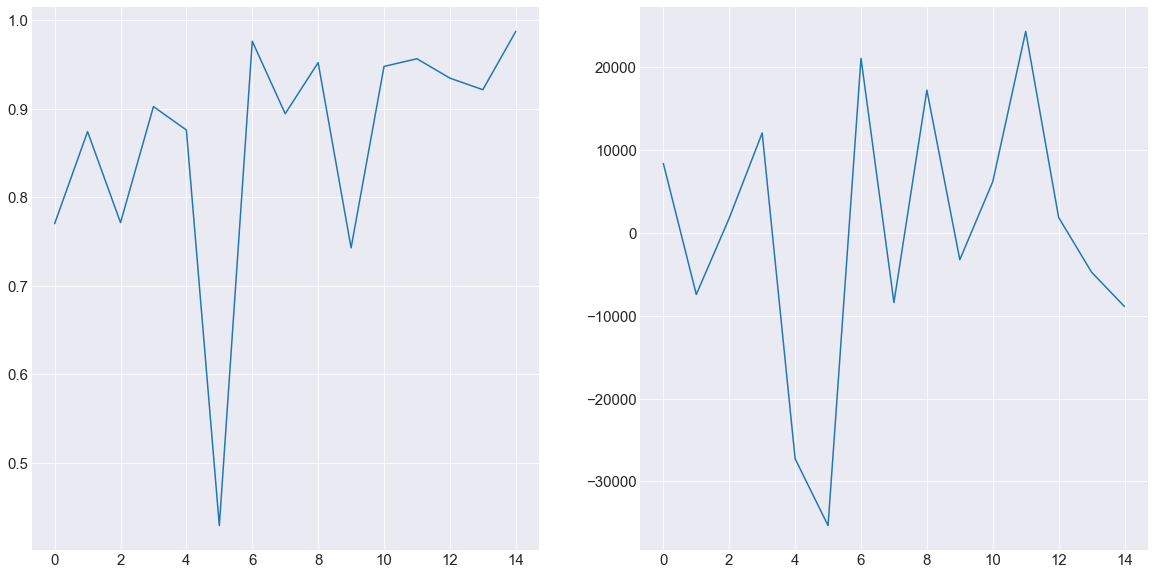

In [77]:
variance = cross_val_score(LR,X_train,y_train,cv=15,scoring=make_scorer(corr))
biass = cross_val_score(LR,X_train,y_train,cv=15,scoring=make_scorer(bias))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,10)
ax[0].plot(range(len(variance)), variance)
ax[1].plot(range(len(biass)), biass)

In [67]:
dfr = pd.DataFrame()
dfr['Real'] = data.iloc[:,-1].values
dfr['Predict'] = LR.predict(data.iloc[:,0:-1])
dfr['Delta'] = dfr['Real'] - dfr['Predict']

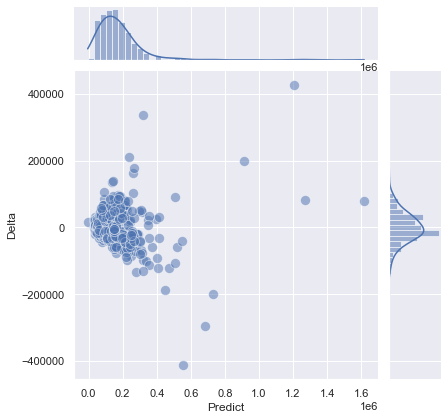

In [68]:
#1.- It has a high density of points close to the origin and a low density of points away from the origin
#2.- It is symmetric about the origin
g = sns.JointGrid(data=dfr, x='Predict', y='Delta')
g.plot_joint(sns.scatterplot, s=100, alpha=.5)
g.plot_marginals(sns.histplot, kde=True)

In [51]:
RFR = RandomForestRegressor(n_estimators = 100, criterion = 'mae', bootstrap = False)
RFR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(X_test)))
print('Test set score:', RFR.score(X_test,y_test))

Train set mse: 1.3856101178004603e-19
Test set mse: 4586206861.780258
Test set score: 0.9000070843470521


<AxesSubplot:>

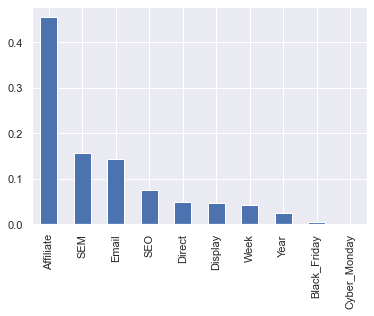

In [52]:
pd.Series(RFR.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:>

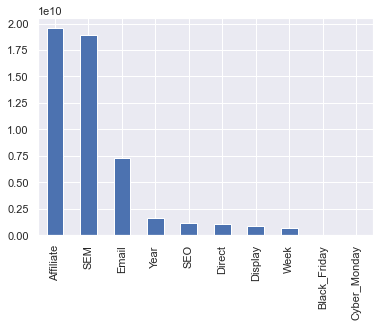

In [53]:
#Permutation Features Importance
results = permutation_importance(RFR, X_train, y_train, n_repeats=100, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
pd.Series(importance, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

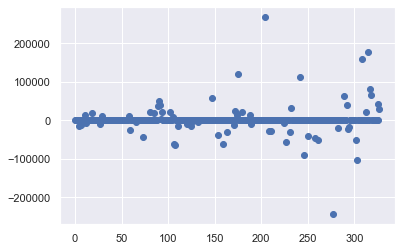

In [54]:
dfr = pd.DataFrame()
dfr['Real'] = data.iloc[:,-1].values
dfr['Predict'] = RFR.predict(data.iloc[:,0:-1])
dfr['Delta'] = dfr['Real'] - dfr['Predict']
plt.scatter(range(len(dfr['Real'])), dfr['Delta'])

In [40]:
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(X_test)))
print('Test set score:', XGB.score(X_test,y_test))

Train set mse: 0.001396040080085938
Test set mse: 2685596952.4236803
Test set score: 0.9414460189793372


<AxesSubplot:>

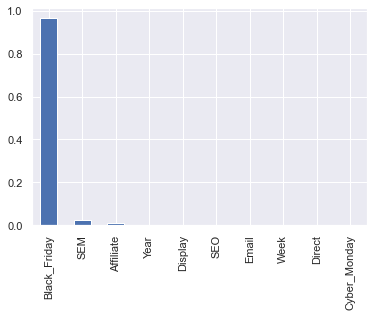

In [38]:
pd.Series(XGB.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:>

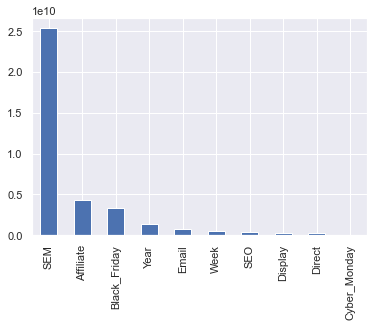

In [50]:
#Permutation Features Importance
results = permutation_importance(XGB, X_train, y_train, n_repeats=100, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
pd.Series(importance, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

In [42]:
LGBM = LGBMRegressor(max_depth=16,num_leaves=2048, n_estimators=200,seed=1)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)

print('Train set mse:', mean_squared_error(y_train, LGBM.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LGBM.predict(X_test)))
print('Test set score:', LGBM.score(X_test,y_test))

Train set mse: 2233988496.4294353
Test set mse: 15791596451.992142
Test set score: 0.6556963478449616


<AxesSubplot:>

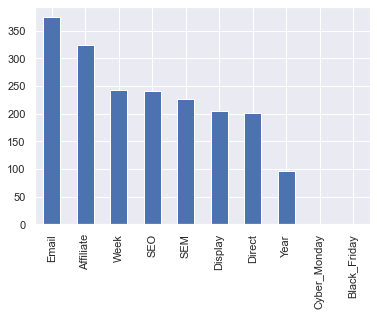

In [37]:
pd.Series(LGBM.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:>

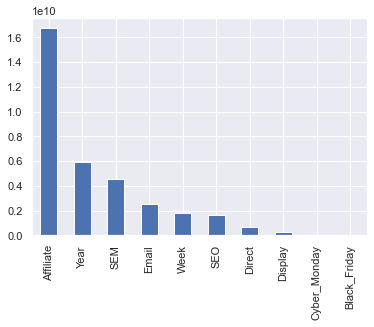

In [51]:
#Permutation Features Importance
results = permutation_importance(LGBM, X_train, y_train, n_repeats=100, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
pd.Series(importance, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

In [122]:
y_pred2 = LR.predict(X_full)

In [123]:
mean_absolute_error(y_full,y_pred2)

42100.98692506857

In [124]:
r2_score(y_full, y_pred2)

0.8587654972822847

In [ ]:
r2_score()

In [41]:
#LR RFR, XGB, LGBM
y_pred2 = RFR.predict(X_full)
print("MAE:", mean_absolute_error(y_full,y_pred2))
print("R2: ", r2_score(y_full, y_pred2))
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_full['Year'].count()), y_full)
plt.plot(range(X_full['Year'].count()), y_pred2, c='r', linewidth=3)

NameError: name 'X_full' is not defined

MAE: 49326.68668070354
R2:  -0.8774535528101521


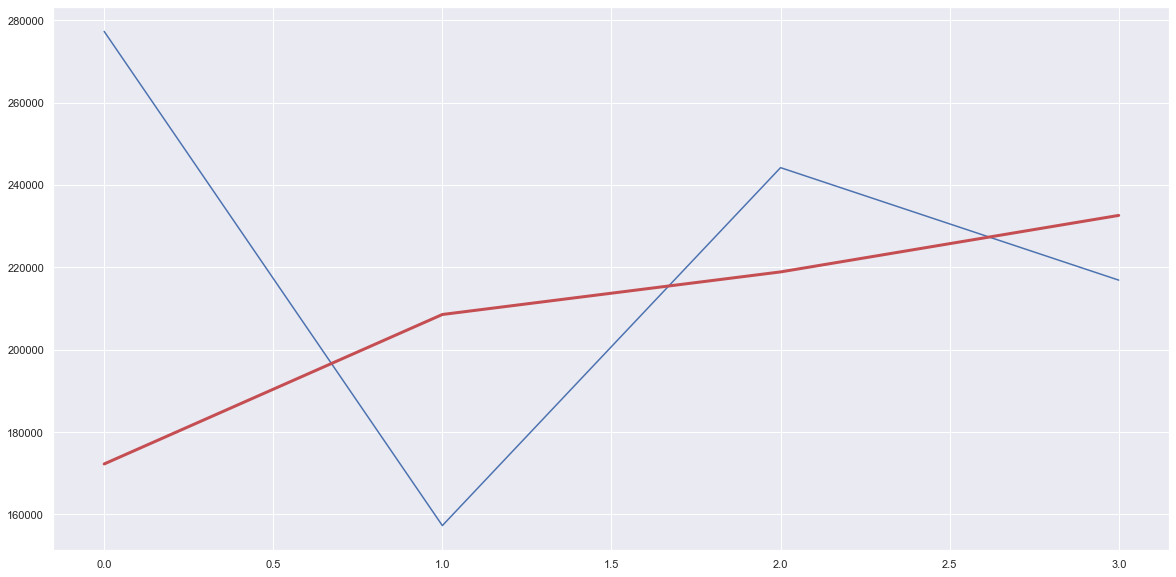

In [49]:
#LR RFR, XGB, LGBM
y_pred2 = LGBM.predict(X_small)
print("MAE:", mean_absolute_error(y_small,y_pred2))
print("R2: ", r2_score(y_small, y_pred2))
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_small['Year'].count()), y_small)
plt.plot(range(X_small['Year'].count()), y_pred2, c='r', linewidth=3)

In [237]:
#Data Contraction via Log
data_log1p = data_consolidated.apply(np.log1p)
data_log1p

,Year,Week,Black_Friday,Cyber_Monday,Affiliate,Direct,Display,Email,SEM,SEO,Revenue
0,7.608871,0.693147,0.0,0.0,3.218876,8.464847,0.000000,4.672829,0.000000,9.665167,9.150649
1,7.608871,1.098612,0.0,0.0,3.583519,9.384126,0.000000,5.545177,8.913550,10.542390,9.765821
2,7.608871,1.386294,0.0,0.0,3.258097,9.148039,0.000000,7.939515,9.134754,10.388226,10.542066
3,7.608871,1.609438,0.0,0.0,2.944439,9.414097,0.000000,5.913503,9.062072,10.376705,10.841218
4,7.608871,1.791759,0.0,0.0,3.713572,9.316501,0.000000,5.398163,8.997271,10.322066,10.241253
...,...,...,...,...,...,...,...,...,...,...,...
323,7.611842,2.397895,0.0,0.0,9.134107,11.568455,10.329213,7.636270,10.046462,10.139152,12.318878
324,7.611842,2.484907,0.0,0.0,8.593784,11.721329,10.455302,7.400010,9.855190,10.136898,12.397084
325,7.611842,2.564949,0.0,0.0,8.597113,11.976395,10.413523,7.311218,9.722086,10.124749,12.197604
326,7.611842,2.639057,0.0,0.0,7.959975,11.588636,9.665357,7.555382,9.567035,9.930859,11.860825


<AxesSubplot:>

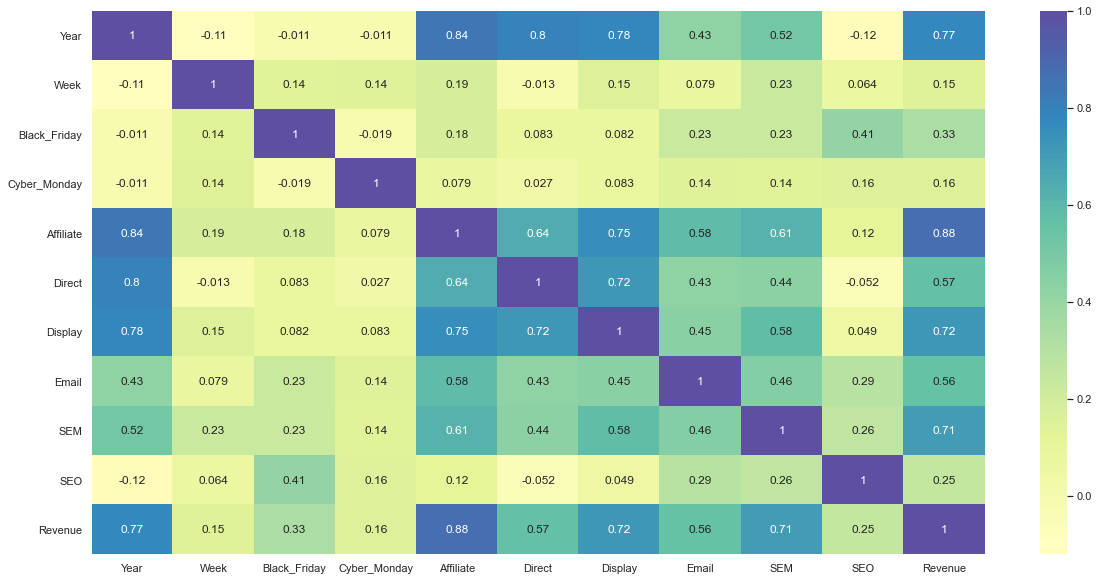

In [238]:
corr = data_log1p.corr()
fig = plt.figure()
fig.set_size_inches(20,10)
#Otra manera
#plt.subplots(figsize=(20, 10))
sns.heatmap(corr, cmap='Spectral', annot=True, center=-0.1)

In [215]:
#Data Normalization
scaler = StandardScaler()
columns = ['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
           'SEO', 'SEM', 'Affiliate', 'Email', 'Display', 'Revenue']
data_scaled = pd.DataFrame(scaler.fit_transform(data_consolidated), columns = columns)

In [286]:
# Data Preparation
X = data_log1p[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']] # pandas DataFrame
y = data_log1p['Revenue'] # pandas Series

In [287]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [116]:
#Regresión Linear

In [397]:
#Regression
reg = LinearRegression()
#Train the model
reg.fit(X_train,y_train)

LinearRegression()

In [398]:
y_pred = reg.predict(X_test)

In [419]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

47077.8999167806

In [420]:
np.sqrt(mean_squared_error(y_test, y_pred))

75948.39333726655

In [479]:
r2_score(y_test, y_pred)

0.874237033174075

In [477]:
#@@@@@@@@@@@@@@@@@@@#

In [478]:
np.mean(reg.predict(X_test)-y_test)

-1820.193607547661

In [493]:
np.corrcoef?

In [484]:
np.corrcoef(reg.predict(X_test),y_test)[0][1]

0.935078279941874

In [489]:
def corr(pred,y_test):
    return np.corrcoef(pred,y_test)[0][1]

def bias(pred,y_test):
    return np.mean(pred-y_test)

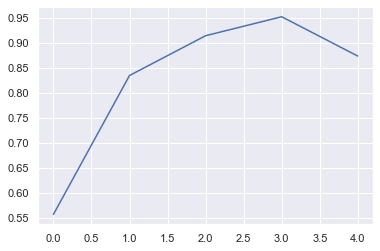

In [495]:
variance = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(corr))
biass = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(bias))
plt.plot(range(len(variance)), variance)

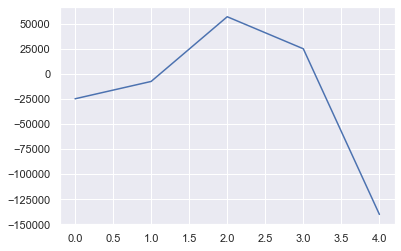

In [494]:
plt.plot(range(len(biass)), biass)

In [497]:
variance = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(corr)).mean()
biass = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(bias)).mean()
variance, biass

(0.8260367383814634, -18259.63031815729)

In [466]:
res = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_absolute_error')
res

array([ -29321.53262093,  -28152.96301003,  -63976.55642234,
        -59183.99112095, -221019.81877881])

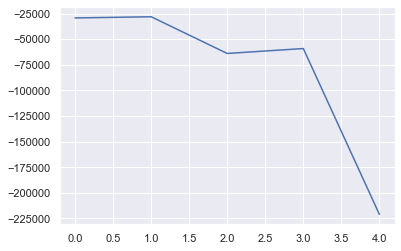

In [467]:
plt.plot(range(len(res)), res)

In [ ]:
#Regresión Gamma

In [123]:
#Regression
reg = GammaRegressor()
#Train the model
reg.fit(X_train,y_train)

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)


GammaRegressor()

In [124]:
y_pred = reg.predict(X_test)

In [125]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

97592.02979777157

In [126]:
np.sqrt(mean_squared_error(y_test, y_pred))

131120.8514649113

In [127]:
r2_score(y_test, y_pred)

-0.008288885574373905

In [ ]:
#K-Vecinos

In [246]:
#K-Neighbors
regk = KNeighborsRegressor(n_neighbors=10)
#Train the model
regk.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=10)

In [248]:
y_pred = regk.predict(X_test)

In [249]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

0.23710276867609345

In [250]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.2944816763478674

In [418]:
r2_score(y_test, y_pred)

0.874237033174075

In [36]:
range(X_test['Year'].count())

range(0, 66)

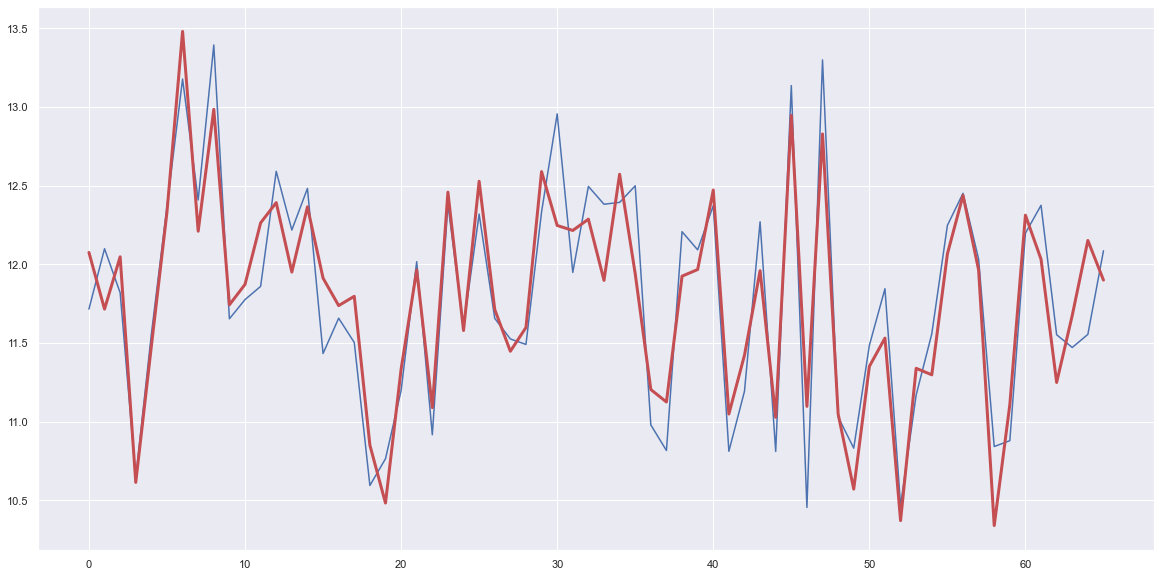

In [293]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_test['Year'].count()), y_test)
plt.plot(range(X_test['Year'].count()), y_pred, c='r', linewidth=3)

In [29]:
myfile = "./data_predict_v1.xlsx"
data_predict = pd.read_excel(myfile)
data_predict

,Date,Program,Visits,Revenue
0,2021-04-12 23:59:59,Direct,1,2484.69
1,2021-04-12 23:59:59,Direct,1,1988.53
2,2021-04-12 23:59:59,Direct,1,1984.02
3,2021-04-12 23:59:59,Direct,1,1696.85
4,2021-04-12 23:59:59,Direct,1,1568.62
...,...,...,...,...
1898,2021-05-09 23:59:59,::unspecified::,21,0.00
1899,2021-05-09 23:59:59,Paid Social,1050,0.00
1900,2021-05-09 23:59:59,Organic Social,19,0.00
1901,2021-05-09 23:59:59,Other,4,0.00


In [28]:
data_predict.isna().sum()
data_predict.dtypes

Date       datetime64[ns]
Program            object
Visits              int64
Revenue           float64
dtype: object

In [30]:
data_predict = convert_dates(data_predict, 'Date')
data_predict = data_predict[['Year', 'Week', 'Program', 'Visits', 'Revenue']]

data_predict = group_programs(data_predict)

program_data_predict = data_predict.groupby(['Year', 'Week', 'Program'])['Visits'].sum().unstack().fillna(value = 0).reset_index()
black_friday_and_cyber_monday_data_predict = get_black_friday_cyber_monday(program_data_predict.iloc[:,0:2])
program_data_predict = pd.merge(black_friday_and_cyber_monday_data_predict, program_data_predict)
data_revenue_predict = data_predict.groupby(['Year', 'Week'])['Revenue'].sum().reset_index()
data_consolidated_predict = pd.concat([program_data_predict, data_revenue_predict['Revenue']], axis = 1)
data_consolidated_predict = data_consolidated_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display', 'Revenue']]
program_data_predict = program_data_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']]

In [30]:
data_consolidated_predict

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2021,15,0,0,101202,23086,21137,3261,1658,12494,277288.61
1,2021,16,0,0,68401,22761,27275,3146,2127,22512,157303.90
2,2021,17,0,0,39055,23616,28314,3832,2196,21476,244209.96
3,2021,18,0,0,31535,21298,20369,3597,2197,17004,216899.81


In [296]:
data_consolidated_predict = data_consolidated_predict.apply(np.log1p)
data_consolidated_predict

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,7.611842,2.772589,0.0,0.0,11.524884,10.047025,9.958828,8.090096,7.413970,9.433084,12.532818
1,7.611842,2.833213,0.0,0.0,11.133157,10.032848,10.213762,8.054205,7.662938,10.021848,11.965941
2,7.611842,2.890372,0.0,0.0,10.572752,10.069722,10.251147,8.251403,7.694848,9.974738,12.405788
3,7.611842,2.944439,0.0,0.0,10.358885,9.966415,9.921819,8.188133,7.695303,9.741263,12.287195


In [297]:
X_pred = data_consolidated_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']] # pandas DataFrame
y_pred = data_consolidated_predict['Revenue'] # pandas Series

In [298]:
y_pred2 = reg.predict(X_pred)

In [299]:
mean_absolute_error(y_pred,y_pred2)

0.2862432021624479

In [301]:
r2_score(y_pred, y_pred2)

-1.160803420425459

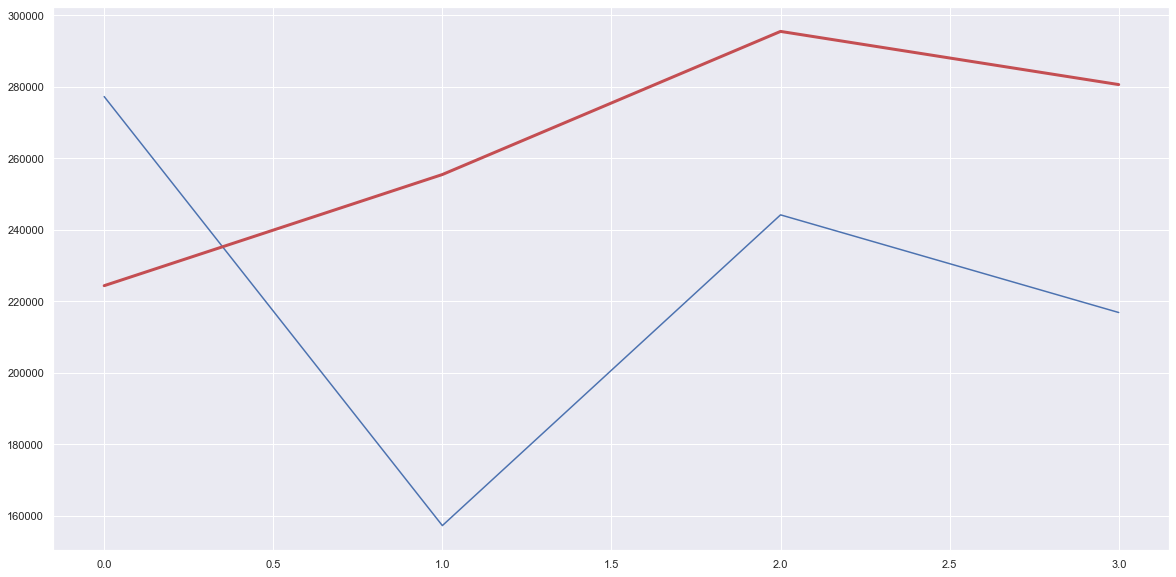

In [303]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_pred['Year'].count()), np.expm1(y_pred))
plt.plot(range(X_pred['Year'].count()), np.expm1(y_pred2), c='r', linewidth=3)

In [82]:
dfr=pd.DataFrame()

In [83]:
dfr=pd.DataFrame()
dfr["real"]=y_test.values
dfr['predct'] = y_pred

In [84]:
dfr

,real,predct
0,122364.910000,156419.220484
1,179681.856133,98718.733737
2,135797.220000,193632.439531
3,41893.220000,75270.050549
4,104407.180000,110950.737614
...,...,...
61,236736.980000,169491.989178
62,103970.730000,83639.820688
63,95888.540000,114202.648525
64,104196.640000,150369.436438


In [410]:
kf = KFold(n_splits=5)

In [414]:
cross_val_score(reg,X,y,cv=10,scoring="r2")

array([ -0.84639769, -28.01207974,   0.35154528,  -1.10986955,
         0.82108121,  -1.11790739,   0.88359317,   0.80537493,
        -0.46556121,   0.77088949])

In [143]:
#Make a copy of the main dataframe
data = new_data[['Program','Year','Month','Day','Visits','Revenue']]

In [8]:
#For this early stage I discard type of Traffic and just sum all of them
data = data.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()

In [9]:
#Reset Index after having made a groupby
data = data.reset_index()

In [10]:
#Lets check it out how this looks like and we can see that we have 2223 rows of data. Original one was 100,033 rows
data

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2218,2021,1,27,39461,36720.96
2219,2021,1,28,41043,30386.56
2220,2021,1,29,39174,65198.11
2221,2021,1,30,29582,33134.80


Let's check the Variability of Pearson
 * High Variability in Revenue
 * Visit Variability is less than Revenue but it is above 0.5


In [11]:
#High Variability in Revenue
pearson_revenue = data['Revenue'].std() / data['Revenue'].mean()
#Visit Variability is less than Revenue but it is above 0.5
pearson_traffic = data['Visits'].std() / data['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue}) and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 1.53995483973178) and Pearson Visits: 0.6361548377691404


In [12]:
data['Revenue'].describe()

count      2223.000000
mean      25438.899731
std       39174.756758
min           0.000000
25%        9351.615000
50%       18048.570000
75%       31929.080000
max      858333.560000
Name: Revenue, dtype: float64

In [13]:
#There are number way above 100.000. Those are some outliners
sorted(data['Revenue'], reverse=True)

[858333.5600000034,
 784321.290000003,
 590327.1899999998,
 563812.3999999989,
 529061.6699999995,
 334605.57000000076,
 311593.59999999957,
 304644.9999999996,
 206742.70999999996,
 192917.33000000007,
 191231.44000000012,
 187432.28999999983,
 186791.86000000004,
 171407.57999999987,
 169560.74000000005,
 167811.78999999986,
 153453.7500000001,
 139222.25999999998,
 132259.49000000002,
 132244.95,
 131383.15999999992,
 130645.76999999989,
 124783.69999999997,
 124024.70000000022,
 117069.57999999999,
 115680.39000000003,
 112899.65000000001,
 111940.03999999998,
 109272.9500000002,
 107702.02999999996,
 107599.70999999995,
 104098.95000000004,
 101380.1800000001,
 100517.25999999995,
 98058.94000000002,
 97243.22999999998,
 95266.08000000016,
 94826.27,
 93087.03000000006,
 92653.50999999995,
 92156.65000000002,
 91074.79,
 90887.97000000009,
 90056.15,
 89374.43000000004,
 88473.35000000008,
 87368.04000000008,
 86168.33999999995,
 84098.13000000002,
 83723.62,
 82678.79,
 81664.65,

(array([ 54., 100., 120., 154., 177., 143., 126., 110., 124., 115.,  95.,
         81.,  79.,  63.,  61.,  66.,  61.,  51.,  55.,  41.,  35.,  26.,
         35.,  34.,  32.,  13.,  15.,  17.,  11.,  10.,  14.,   9.,   6.,
         13.,   2.,   6.,   5.,   4.,   5.,   1.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   2.,   1.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

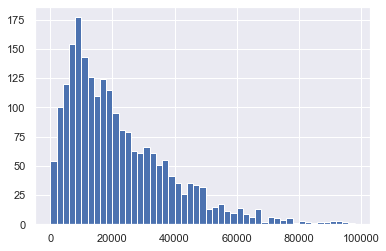

In [14]:
plt.hist(data['Revenue'], bins=range(0,100000,2000))

(array([3., 3., 2., 2., 2., 0., 4., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
        2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000,
        140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000,
        180000, 185000, 190000, 195000, 200000, 20

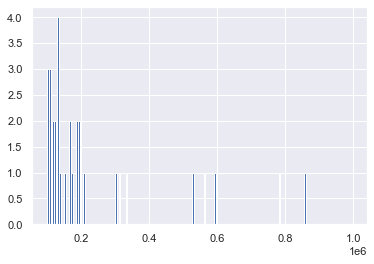

In [15]:
#Let's see the outliners
plt.hist(data['Revenue'], bins=range(100000,1000000,5000))

In [16]:
#We have 34 outliners out of more than 2000 records
data[data['Revenue'] > 100000]['Revenue'].value_counts().sum()

34

In [17]:
data['Visits'].describe()

count      2223.000000
mean      12871.529015
std        8188.285452
min         245.000000
25%        7774.000000
50%        9969.000000
75%       14886.000000
max      109148.000000
Name: Visits, dtype: float64

In [18]:
data['Visits'].max()

109148

(array([  1.,   9., 159., 449., 501., 309., 190.,  92.,  84.,  88.,  77.,
         48.,  55.,  28.,  25.,  31.,  10.,  10.,   7.,   9.,  15.,  11.,
          6.,   2.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

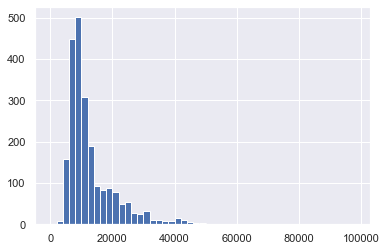

In [19]:
plt.hist(data['Visits'], bins=range(0,100000,2000))

In [20]:
#Let's see the correlation across the variables
data.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.044018,0.001226,0.659991,0.305776
Month,-0.044018,1.000000,0.009158,0.168876,0.128174
Day,0.001226,0.009158,1.000000,0.074226,0.088392
Visits,0.659991,0.168876,0.074226,1.000000,0.591148
Revenue,0.305776,0.128174,0.088392,0.591148,1.000000


In [21]:
#Now let's try to apply log to the variables, except when the value is 0 (inf.)
data_log = pd.DataFrame(np.log(data[data['Revenue'] != 0]))

In [22]:
#Now we can see a different correlation matrix. Visits still quite correlate with Revenue but Year as well
data_log.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.063566,0.001097,0.732171,0.604629
Month,-0.063566,1.000000,0.005938,0.092400,0.109626
Day,0.001097,0.005938,1.000000,0.054783,0.076481
Visits,0.732171,0.092400,0.054783,1.000000,0.675325
Revenue,0.604629,0.109626,0.076481,0.675325,1.000000


In [23]:
#Bear in mind that we are using Log e and therefore Pearson results are different
pearson_revenue = data_log['Revenue'].std() / data_log['Revenue'].mean()
pearson_traffic = data_log['Visits'].std() / data_log['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue} and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 0.09859521582003562 and Pearson Visits: 0.05443959700737877


In [24]:
data_log['Revenue'].describe()

count    2217.000000
mean        9.720446
std         0.958389
min         3.837730
25%         9.153696
50%         9.804346
75%        10.374114
max        13.662748
Name: Revenue, dtype: float64

(array([  0.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   3.,   0.,   2.,   1.,   4.,   5.,   6.,  12.,  18.,  29.,
         35.,  52.,  59., 111., 134., 174., 176., 207., 244., 204., 212.,
        208., 143.,  79.,  41.,  20.,  10.,   6.,   7.,   1.,   2.,   1.,
          0.,   3.,   0.,   2.,   0.]),
 array([ 3.        ,  3.2244898 ,  3.44897959,  3.67346939,  3.89795918,
         4.12244898,  4.34693878,  4.57142857,  4.79591837,  5.02040816,
         5.24489796,  5.46938776,  5.69387755,  5.91836735,  6.14285714,
         6.36734694,  6.59183673,  6.81632653,  7.04081633,  7.26530612,
         7.48979592,  7.71428571,  7.93877551,  8.16326531,  8.3877551 ,
         8.6122449 ,  8.83673469,  9.06122449,  9.28571429,  9.51020408,
         9.73469388,  9.95918367, 10.18367347, 10.40816327, 10.63265306,
        10.85714286, 11.08163265, 11.30612245, 11.53061224, 11.75510204,
        11.97959184, 12.20408163, 12.42857143, 12.65306122, 12.87755102,
       

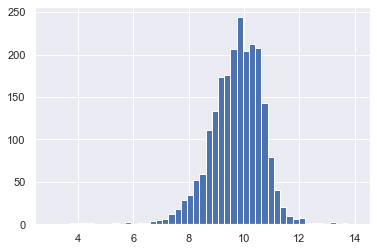

In [25]:
plt.hist(data_log['Revenue'], bins=np.linspace(start=3,stop=14,num=50))

In [26]:
data_log['Visits'].describe()

count    2217.000000
mean        9.320332
std         0.507395
min         8.148156
25%         8.960468
50%         9.208238
75%         9.609787
max        11.600460
Name: Visits, dtype: float64

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   7.,  12.,  38.,  66.,  67., 110., 195., 215., 217., 251.,
        180., 131., 122.,  71.,  66.,  87.,  86.,  66.,  63.,  37.,  48.,
         14.,  19.,  26.,  12.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.]),
 array([ 7.        ,  7.10204082,  7.20408163,  7.30612245,  7.40816327,
         7.51020408,  7.6122449 ,  7.71428571,  7.81632653,  7.91836735,
         8.02040816,  8.12244898,  8.2244898 ,  8.32653061,  8.42857143,
         8.53061224,  8.63265306,  8.73469388,  8.83673469,  8.93877551,
         9.04081633,  9.14285714,  9.24489796,  9.34693878,  9.44897959,
         9.55102041,  9.65306122,  9.75510204,  9.85714286,  9.95918367,
        10.06122449, 10.16326531, 10.26530612, 10.36734694, 10.46938776,
        10.57142857, 10.67346939, 10.7755102 , 10.87755102, 10.97959184,
        11.08163265, 11.18367347, 11.28571429, 11.3877551 , 11.48979592,
       

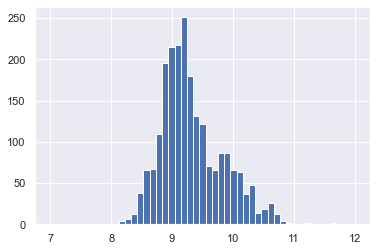

In [27]:
plt.hist(data_log['Visits'], bins=np.linspace(start=7,stop=12,num=50))

In [28]:
#This is a new DataFrame 
data_by_year_month = data.groupby(['Year','Month'])[['Visits','Revenue']].sum()
data_by_year_month = data_by_year_month.reset_index()

In [29]:
def back_poly_parameters(l,i,x):
    """
    DESCRIPTION
      This function return a vector of coefficients for plotting easily. It is using backtracking
    ARGUMENTS
      l: list of coefficients from np.polyfit, it does not matter the degree
      i: This is the len of the list
      x: It is the X parameter
    RETURN
      A value p[0] * x**deg + ... + p[deg]
    """
    if i == 0:
        return 0
    else:
        #Empiezo de atrás hacia adelante porque el primer polinomio es x^y...hasta b
        #Si el índice tiene 3 elementos entonces x²+x+b y así sucesivamente
        return l[-i]*x**(i-1) + back_poly_parameters(l,i-1,x)

In [43]:
x = data_by_year_month.index
#Lets prepare a polynomial regression line for Revenue
y_revenue = data_by_year_month['Revenue']
d_r = 4 #This is the degree for the polynomial
list_revenue = np.polyfit(x, y_revenue, d_r)

#Lets prepare a polynomial regression line for Revenue
y_visits = data_by_year_month['Visits']
d_v = 4 #This is the degree for the polynomial
list_visits = np.polyfit(x, y_visits, d_v)

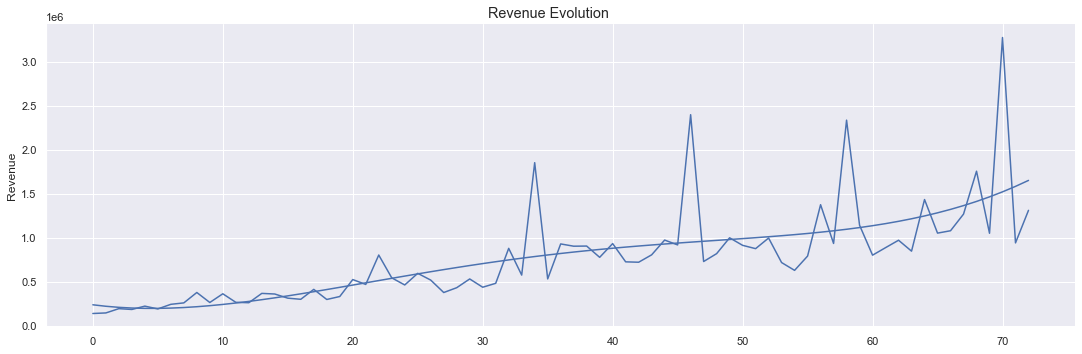

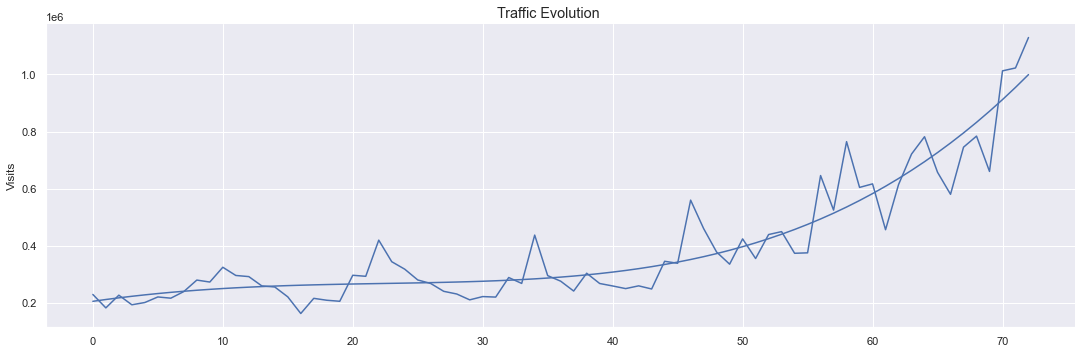

In [44]:
#Here we can see the trend across the months in Revenue and Visits and we draw another line.
#Actually that line is a polynomial line, in the Revenue case, it is a pure line because degree=2 does not
#Show any difference. However, the Visits chart is adjusting much better with a degree=2 or even 3
g = sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Revenue', kind='line', aspect=3).fig.suptitle('Revenue Evolution')
plt.plot(x, back_poly_parameters(list_revenue, len(list_revenue), x))
#plt.axvline(100, color="r", linestyle="--");
sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Visits', kind='line', aspect=3).fig.suptitle('Traffic Evolution')
plt.plot(x, back_poly_parameters(list_visits, len(list_visits), x))

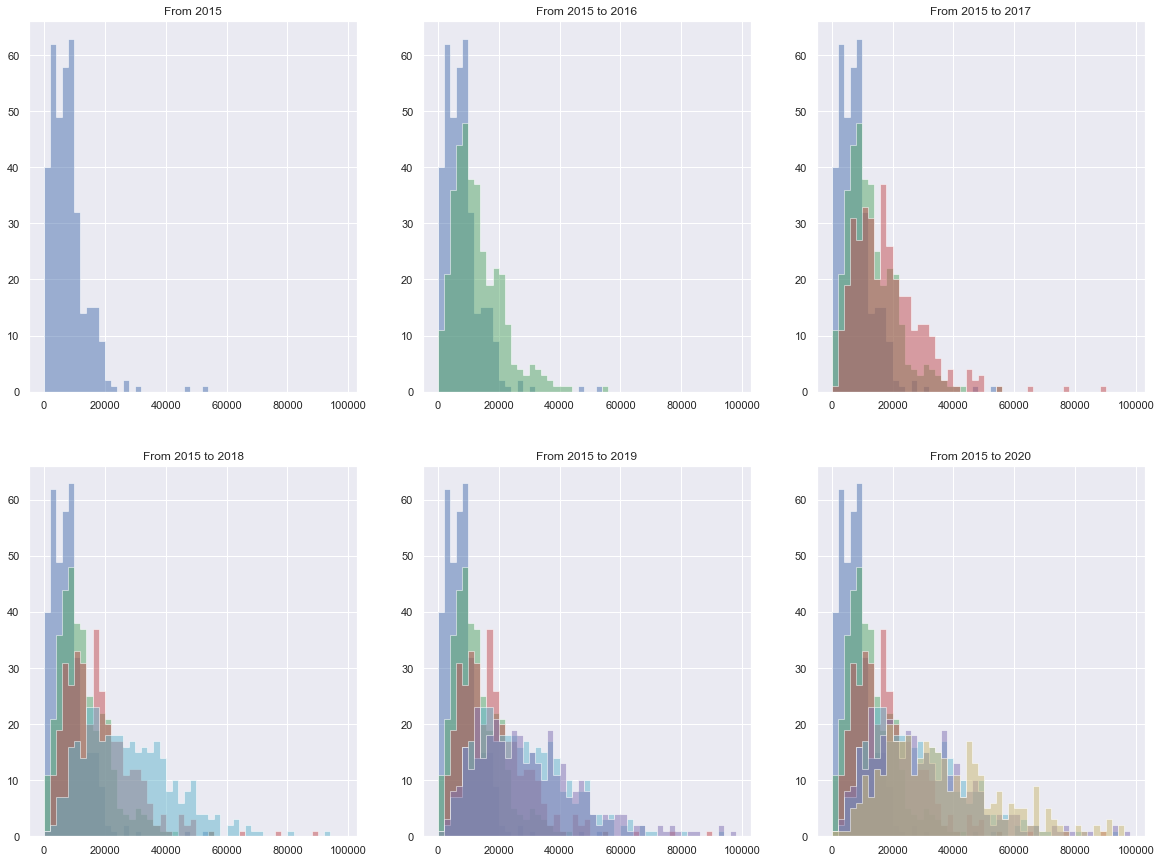

In [32]:
#It seems the Revenue distribution follows a Gamma Distribution even when you add the rest of the years
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,100000,2000), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Revenue', 'Year', data['Year'].unique(), ax)

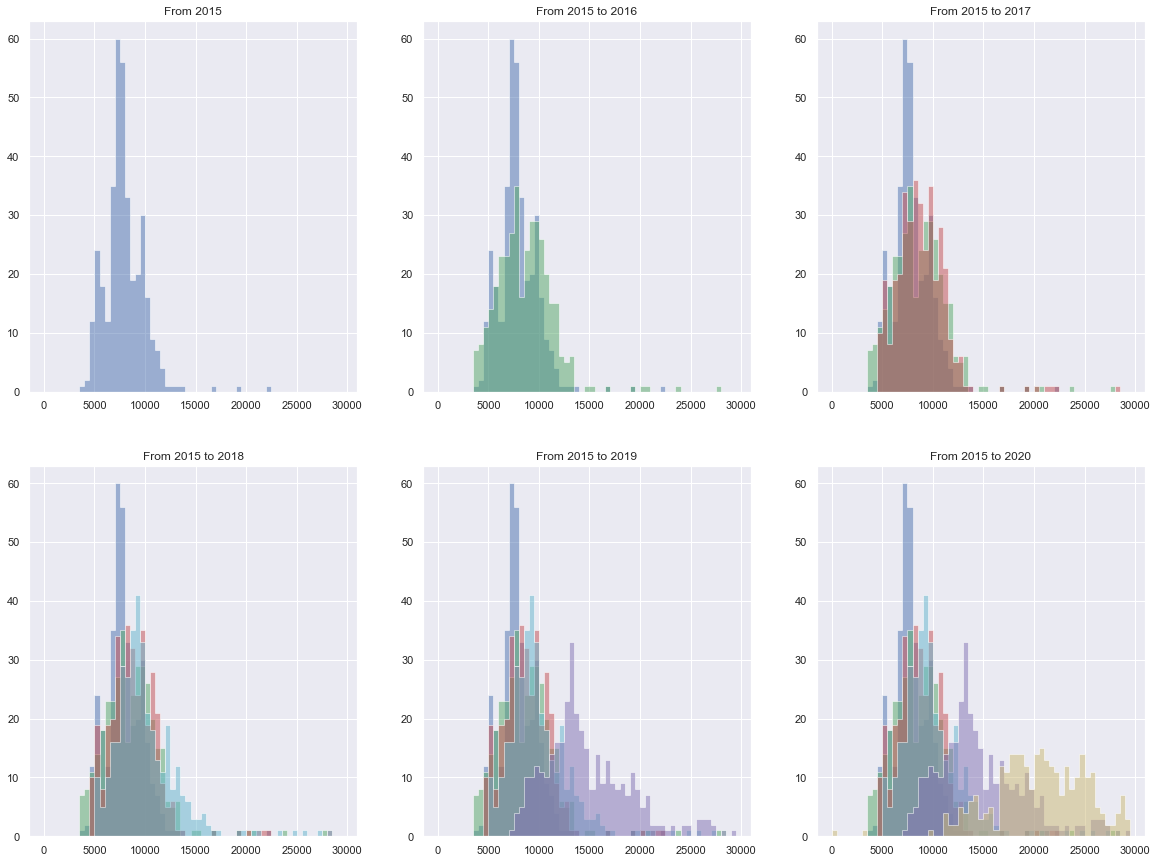

In [33]:
#Traffic seems a Norm Distribution but when you add more years it seems a Gamma Distribution but every year
#Seems centrated. Further analysis are needed
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,30000,500), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Visits', 'Year', data['Year'].unique(), ax)

In [34]:
np.median(data['Revenue'])

18048.57

In [35]:
np.mean(data['Revenue'])

25438.899730604302

In [36]:
data['Revenue'].kurtosis()

206.35291518972994

In [37]:
data['Visits'].kurtosis()
#Leptocurtica

12.811651479904462

In [38]:
data['Revenue'].skew()
#Asimétrica a la derecha

12.066027764425613

In [39]:
data['Visits'].skew()

2.5753619816927293

In [40]:
from sklearn.metrics import r2_score

In [71]:
data_big.head()

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2015,1,0,0,4744,15758,0,24,106,0,9419.55
1,2015,2,0,0,11897,37887,7431,35,255,0,17426.79
2,2015,3,0,0,9395,32474,9271,25,2805,0,37874.74
3,2015,4,0,0,12259,32102,8621,18,369,0,51082.54
4,2015,5,0,0,11119,30395,8080,40,220,0,28035.24


# NO TOCAR

In [439]:
data_exp = data_big.copy()
data_exp["Rev -1"] = data_exp["Revenue"].shift(1)
data_exp["Rev -2"] = data_exp["Revenue"].shift(2)

data_exp.dropna(inplace=True)

# Time Series

# Analisis Aditivo o Multiplicativo
Es multiplicativo porque es una línea creciente

TEndencia, Ciclo, Estación y Residuo => Puede ser aditivo o multiplicativo

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


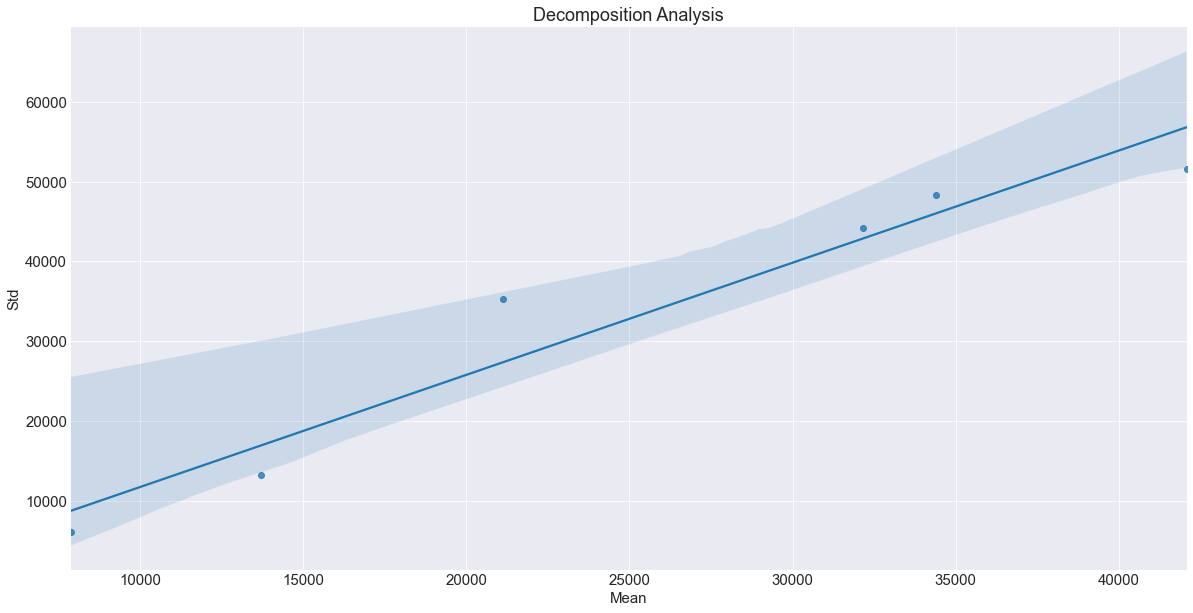

In [958]:
draw_decomposition(data_small)

It seems a Multiplicative Decomposition Model when the data is grouped at daily basis

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


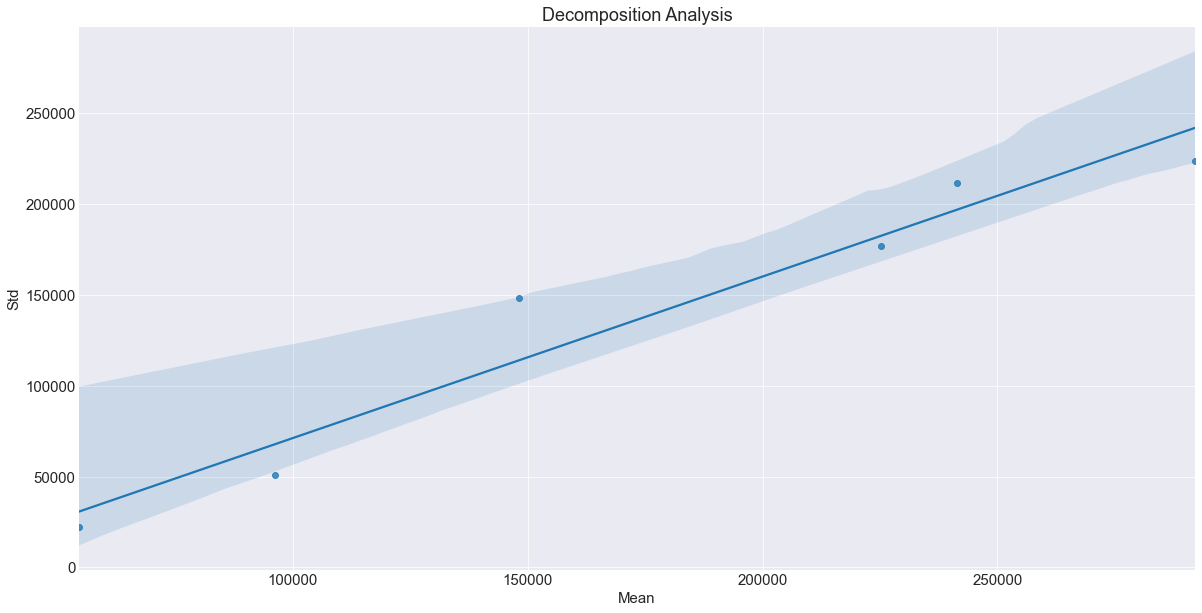

In [959]:
draw_decomposition(data_big)

It seems a AdditiveDecomposition Model when the data is grouped at weekly basis

## Time series decomposition 

Daily basis Model

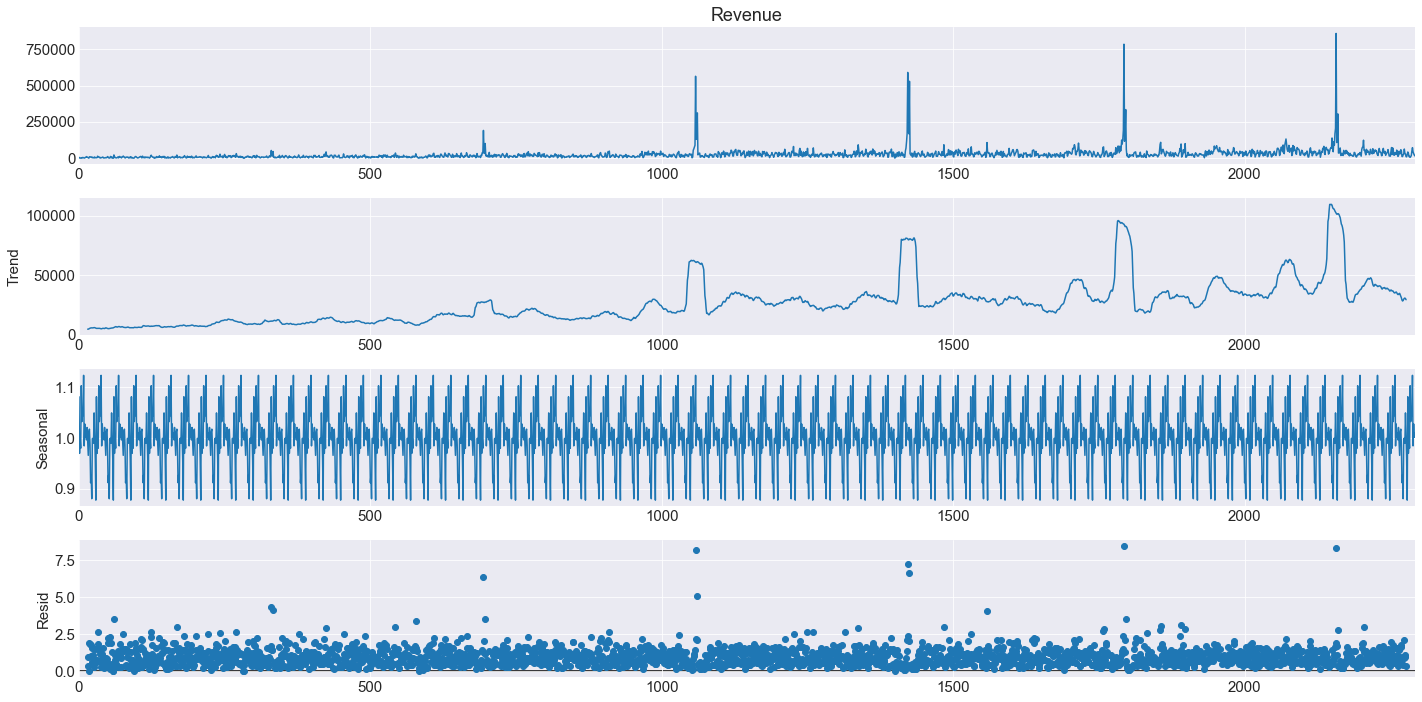

In [964]:
s_d_small = seasonal_decompose(data_small['Revenue'], period= 30, model= 'multiplicative')
s_d_small.plot();

Weekly basis Model

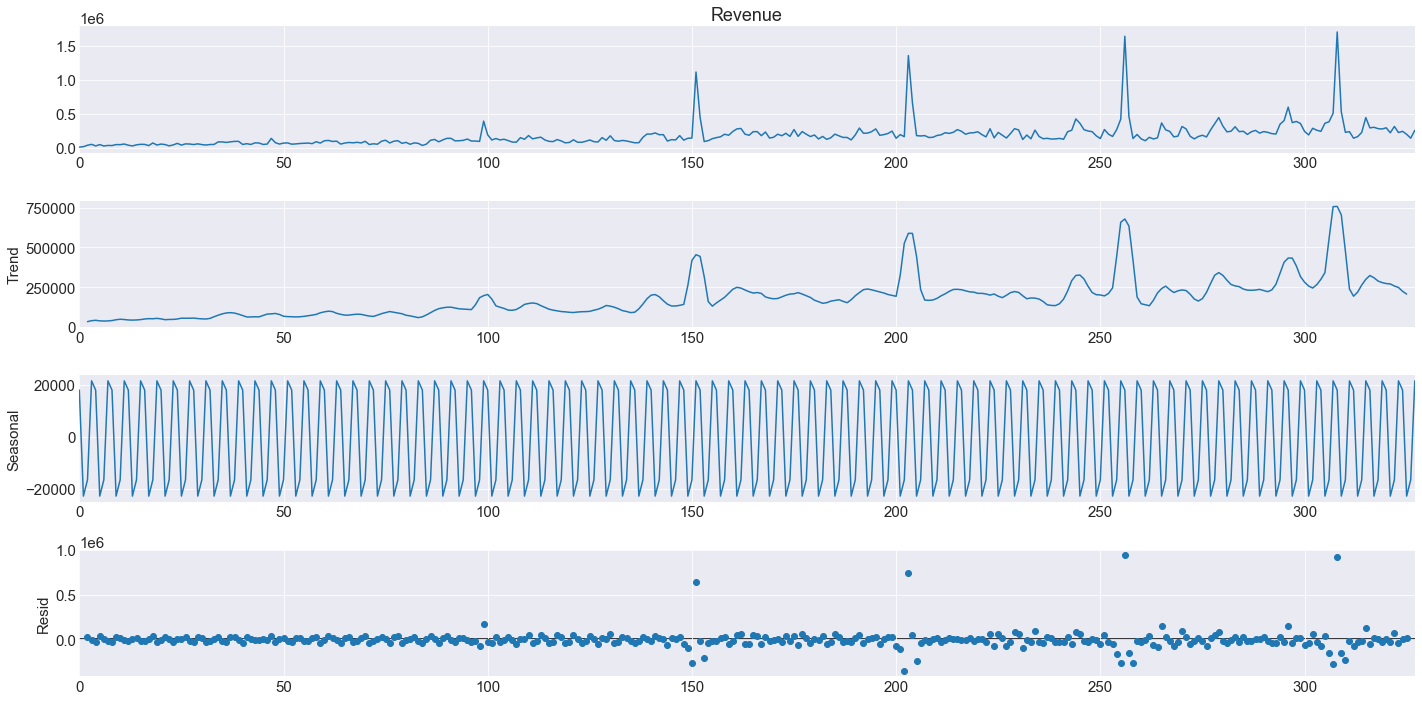

In [965]:
s_d_big = seasonal_decompose(data_big['Revenue'], period= 4, model= 'additive')
s_d_big.plot();

## Autocorrelation and Partial Autocorrelation

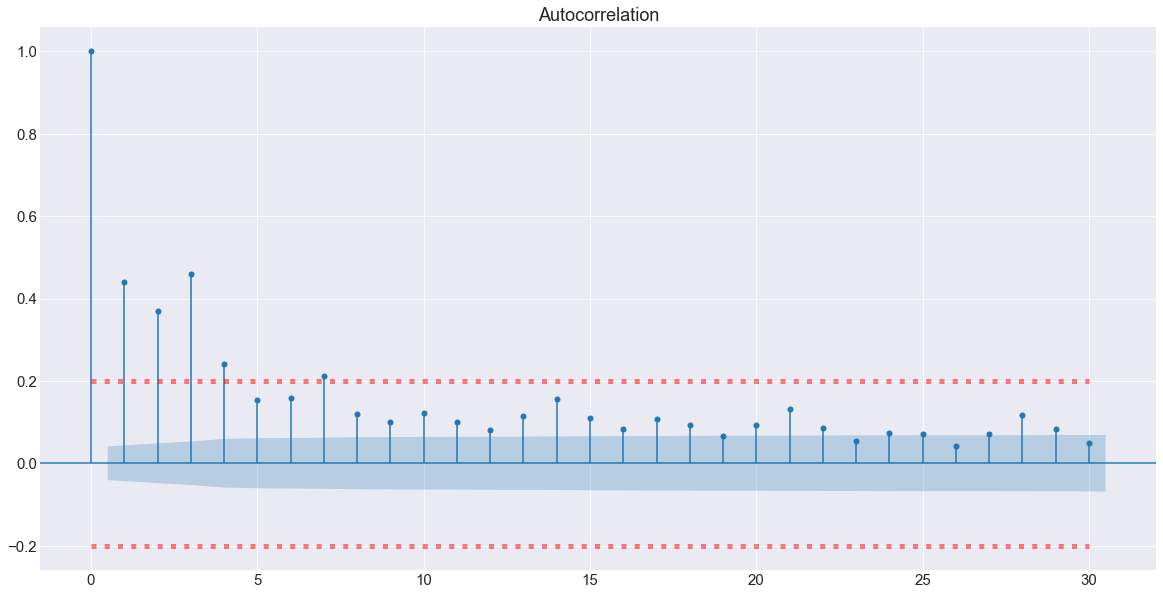

In [973]:
draw_autocorrelation(data_small, 'auto', 30)

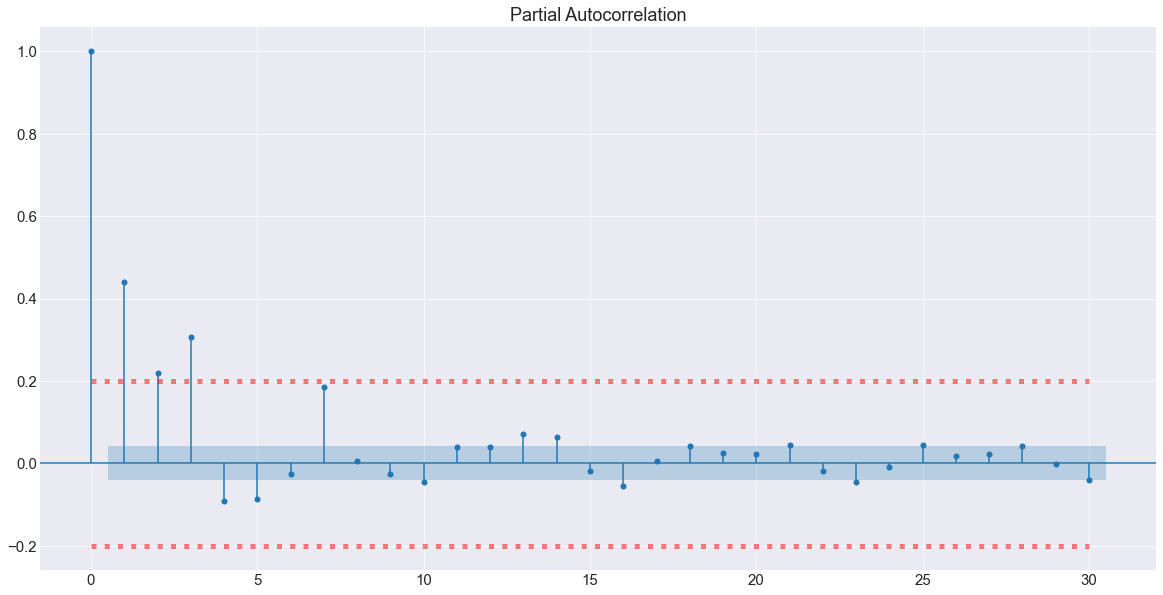

In [974]:
draw_autocorrelation(data_small, 'partial', 30)

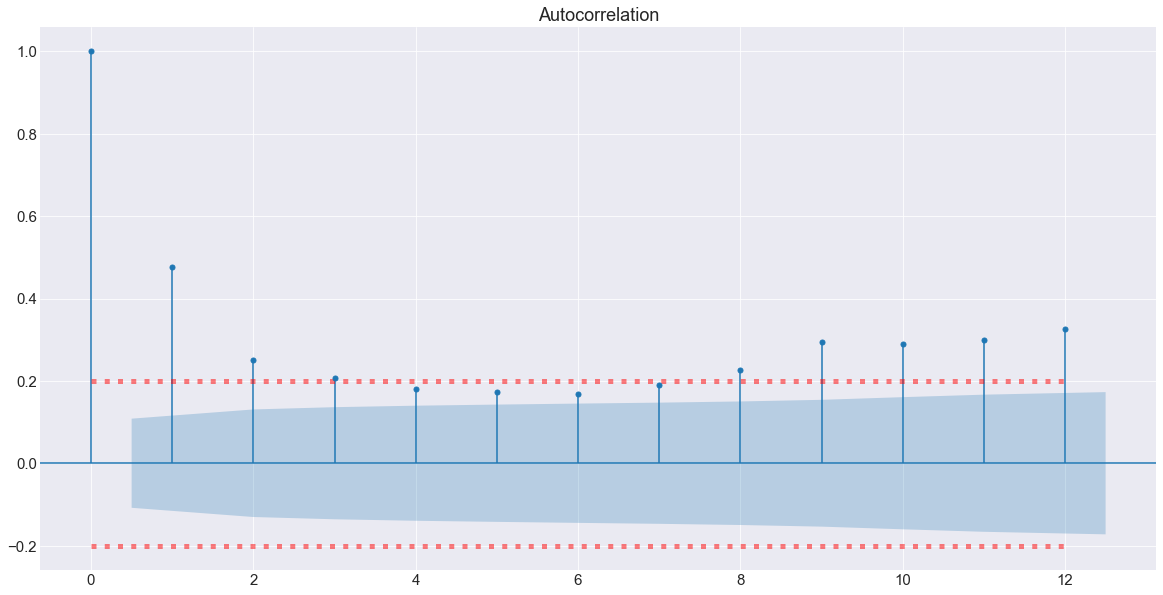

In [977]:
draw_autocorrelation(data_big, 'auto', 12)

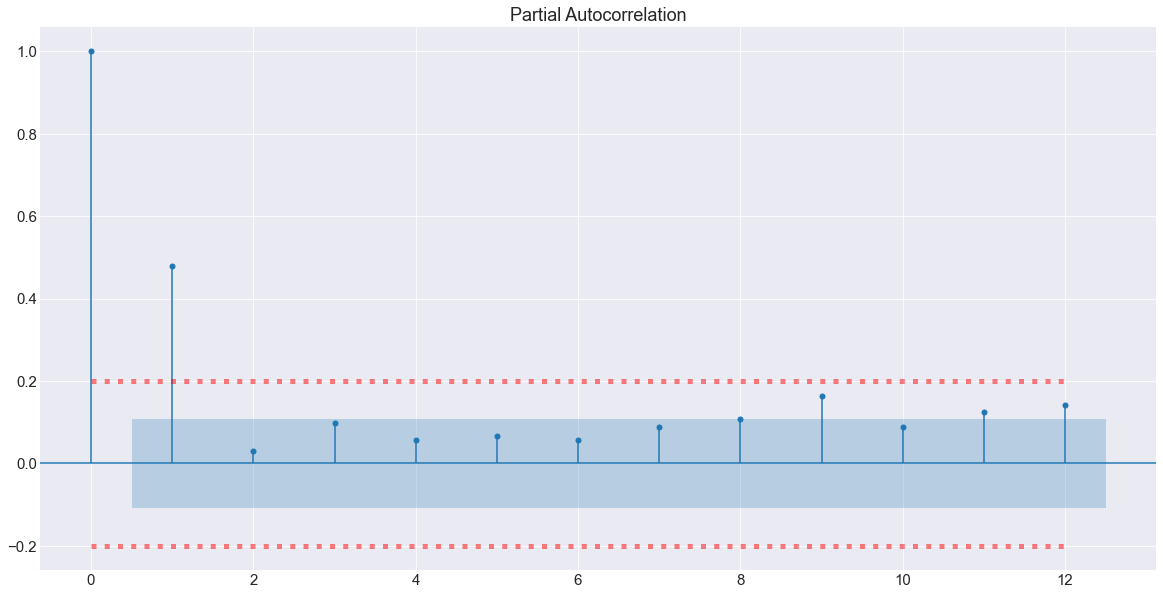

In [978]:
draw_autocorrelation(data_big, 'partial', 12)

## White Noise
Random Walk - Dickey-Fuller test

H0: β = 0 (This is a random walk)

H1: β < 0 (This is not a random walk)

In [574]:
test_adf(data_small, 'Revenue')

** Augmented Dickey-Fuller Test **

T-test: -7.000968604662691 < Confidence Interval: -3.43323655938138 - Result: Stationary
T-test: -7.000968604662691 < Confidence Interval: -2.86281520927122 - Result: Stationary
T-test: -7.000968604662691 < Confidence Interval: -2.567448852970086 - Result: Stationary

P-Value: 7.32383597947612e-10 < 0.05 - Result: Stationary


In [575]:
test_adf(data_big, 'Revenue')

** Augmented Dickey-Fuller Test **

T-test: -2.3082165125000897 > Confidence Interval: -3.4512146067362317 - Result: No Stationary
T-test: -2.3082165125000897 > Confidence Interval: -2.870730188960711 - Result: No Stationary
T-test: -2.3082165125000897 > Confidence Interval: -2.5716664849383113 - Result: No Stationary

P-Value: 0.16933167517757752 > 0.05 - Result: No Stationary


In [996]:
data_small

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2288,2021,4,7,26501,72689.94
2289,2021,4,8,24397,43742.25
2290,2021,4,9,23445,31925.36
2291,2021,4,10,15016,23028.97


In [1001]:
data_exp = pd.DataFrame()

In [1002]:
for i in range(len(data_small)-2, 0 ,-365):
    data_exp[f'Rev-{i}'] = data_small["Revenue"].shift(i) #OJO que empieza en 0!
data_exp['Revenue'] = data_small["Revenue"]
data_exp

,Rev-2291,Rev-1926,Rev-1561,Rev-1196,Rev-831,Rev-466,Rev-101,Revenue
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3244.55
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4791.64
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.93
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,848.43
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2393.52
...,...,...,...,...,...,...,...,...
2288,NaN,6407.68,31595.68,29447.51,35246.36,16699.21,15100.02,72689.94
2289,NaN,9870.95,22119.08,28687.50,16646.03,8024.64,39791.03,43742.25
2290,NaN,7688.27,17809.13,12959.47,15883.35,17509.79,38652.47,31925.36
2291,3244.55,6785.55,8704.46,14577.27,28509.32,12801.71,24401.37,23028.97


In [982]:
len(data_small) / 52

44.09615384615385

In [986]:
data_exp

,Rev-2293,Rev-2241,Rev-2189,Rev-2137,Rev-2085,Rev-2033,Rev-1981,Rev-1929,Rev-1877,Rev-1825,Rev-1773,Rev-1721,Rev-1669,Rev-1617,Rev-1565,Rev-1513,Rev-1461,Rev-1409,Rev-1357,Rev-1305,Rev-1253,Rev-1201,Rev-1149,Rev-1097,Rev-1045,Rev-993,Rev-941,Rev-889,Rev-837,Rev-785,Rev-733,Rev-681,Rev-629,Rev-577,Rev-525,Rev-473,Rev-421,Rev-369,Rev-317,Rev-265,Rev-213,Rev-161,Rev-109,Rev-57,Rev-5
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,NaN,2953.43,6305.70,3984.40,5635.70,5344.80,9566.66,1825.62,13368.78,13412.13,21383.89,10628.60,4835.77,23631.81,7432.66,16846.44,24448.04,32338.86,18151.43,17462.51,10442.10,8154.92,30244.96,19226.96,43263.14,29567.86,19941.11,8168.12,8643.70,26761.41,40988.99,35622.01,25264.52,22875.15,49677.76,6697.54,36382.14,14610.96,59541.01,33034.40,57897.22,30304.97,19349.08,67297.00,12551.94
2289,NaN,4363.87,2909.18,9154.38,6930.10,14685.81,9904.72,8008.34,18923.04,1887.00,17090.81,6668.76,21064.76,19347.47,5865.36,20623.85,2570.76,13932.50,15326.06,45331.41,21002.98,8558.32,46172.50,6472.91,16381.75,28954.95,29377.77,629.19,7420.26,49517.34,5881.38,42508.61,28344.78,48155.67,37261.18,13681.64,38128.18,16636.99,25035.17,37868.16,88473.35,55954.91,16394.86,43148.40,5621.44
2290,NaN,11387.68,1352.61,858.19,7703.58,18048.57,11048.88,16351.42,5987.22,14858.59,14802.23,3728.60,29005.99,15801.53,14459.68,24299.11,2702.92,12832.91,3366.35,31625.93,17835.79,8170.03,50787.01,20910.40,35417.74,18461.24,25733.51,28622.20,12065.78,55973.84,16393.00,59133.54,5288.09,48359.76,11404.93,19859.00,35962.44,15081.01,43710.30,10378.26,41461.61,53373.48,33802.73,42123.44,11002.49
2291,NaN,8573.08,3573.10,7157.46,6433.27,11499.03,6241.98,6407.68,6152.02,11900.88,18072.21,4617.89,24253.18,11276.01,26793.51,14448.21,16924.00,10061.28,9283.20,45115.77,9207.91,26231.06,22710.68,30217.74,15619.58,17277.76,62287.76,14531.88,14451.33,44119.99,107702.03,59545.18,3471.81,64668.97,12133.96,10417.85,34166.27,27745.97,41252.52,17627.46,63093.48,6801.27,22441.93,37277.05,18880.73


In [847]:
data_exp = data_big.copy()
data_exp["Rev -1"] = data_exp["Revenue"].shift(1)
data_exp["Rev -2"] = data_exp["Revenue"].shift(2)

data_exp.dropna(inplace=True)

In [848]:
data_exp

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue,Rev -1,Rev -2
2,2015,3,0,0,9395,32474,9271,25,2805,0,37874.74,17426.79,9419.55
3,2015,4,0,0,12259,32102,8621,18,369,0,51082.54,37874.74,17426.79
4,2015,5,0,0,11119,30395,8080,40,220,0,28035.24,51082.54,37874.74
5,2015,6,0,0,10037,27749,7367,18,1087,62,47267.60,28035.24,51082.54
6,2015,7,0,0,10552,24753,8867,18,1355,59,27090.70,47267.60,28035.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2021,10,0,0,105709,25314,23073,9265,2071,30613,223881.90,313609.70,220552.72
324,2021,11,0,0,123170,25257,19056,5397,1635,34727,242093.55,223881.90,313609.70
325,2021,12,0,0,158957,24952,16681,5415,1496,33306,198312.41,242093.55,223881.90
326,2021,13,0,0,107864,20554,14285,2863,1910,15761,141608.06,198312.41,242093.55


In [859]:
data_exp = pd.DataFrame()
for i in range(365, 0 ,-1):
    data_exp[f'Rev-{i}'] = data_small["Revenue"].shift(i) #OJO que empieza en 0!
data_exp['Revenue'] = data_small["Revenue"]
data_exp.dropna(inplace= True)
data_exp

,Rev-365,Rev-364,Rev-363,Rev-362,Rev-361,Rev-360,Rev-359,Rev-358,Rev-357,Rev-356,Rev-355,Rev-354,Rev-353,Rev-352,Rev-351,Rev-350,Rev-349,Rev-348,Rev-347,Rev-346,Rev-345,Rev-344,Rev-343,Rev-342,Rev-341,Rev-340,Rev-339,Rev-338,Rev-337,Rev-336,Rev-335,Rev-334,Rev-333,Rev-332,Rev-331,Rev-330,Rev-329,Rev-328,Rev-327,Rev-326,Rev-325,Rev-324,Rev-323,Rev-322,Rev-321,Rev-320,Rev-319,Rev-318,Rev-317,Rev-316,...,Rev-49,Rev-48,Rev-47,Rev-46,Rev-45,Rev-44,Rev-43,Rev-42,Rev-41,Rev-40,Rev-39,Rev-38,Rev-37,Rev-36,Rev-35,Rev-34,Rev-33,Rev-32,Rev-31,Rev-30,Rev-29,Rev-28,Rev-27,Rev-26,Rev-25,Rev-24,Rev-23,Rev-22,Rev-21,Rev-20,Rev-19,Rev-18,Rev-17,Rev-16,Rev-15,Rev-14,Rev-13,Rev-12,Rev-11,Rev-10,Rev-9,Rev-8,Rev-7,Rev-6,Rev-5,Rev-4,Rev-3,Rev-2,Rev-1,Revenue
365,3244.55,4791.64,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,...,8349.37,4629.85,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55
366,4791.64,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,...,4629.85,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55,4017.26
367,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,2097.52,...,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55,4017.26,2398.62
368,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,2097.52,1081.02,...,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785

In [863]:
X_train, X_test, y_train, y_test = data_split(*data_preparation(data_exp))

In [864]:
RFR = RandomForestRegressor(n_estimators = 100, criterion = 'mse', bootstrap = False)
RFR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(X_test)))
print('Test set score:', RFR.score(X_test,y_test))

Train set mse: 6.286380386389832e-21
Test set mse: 1595776339.0125375
Test set score: -0.3427028067941966


In [865]:
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(X_test)))
print('Test set score:', XGB.score(X_test,y_test))

Train set mse: 4.786535609762915e-05
Test set mse: 394749318.2674679
Test set score: 0.6678538184456309


In [866]:
LR = LinearRegression()
LR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(X_test)))
print('Test set score:', LR.score(X_test,y_test))

Train set mse: 745222996.6364201
Test set mse: 494920668.2078669
Test set score: 0.5835686028817969


In [867]:
def corr(pred,y_test):
    return np.corrcoef(pred,y_test)[0][1]

def bias(pred,y_test):
    return np.mean(pred-y_test)

(array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.]),
 array([-5254.07957023, -4167.59546265, -3081.11135508, -1994.6272475 ,
         -908.14313992,   178.34096766,  1264.82507523,  2351.30918281,
         3437.79329039,  4524.27739796,  5610.76150554]),
 <BarContainer object of 10 artists>)

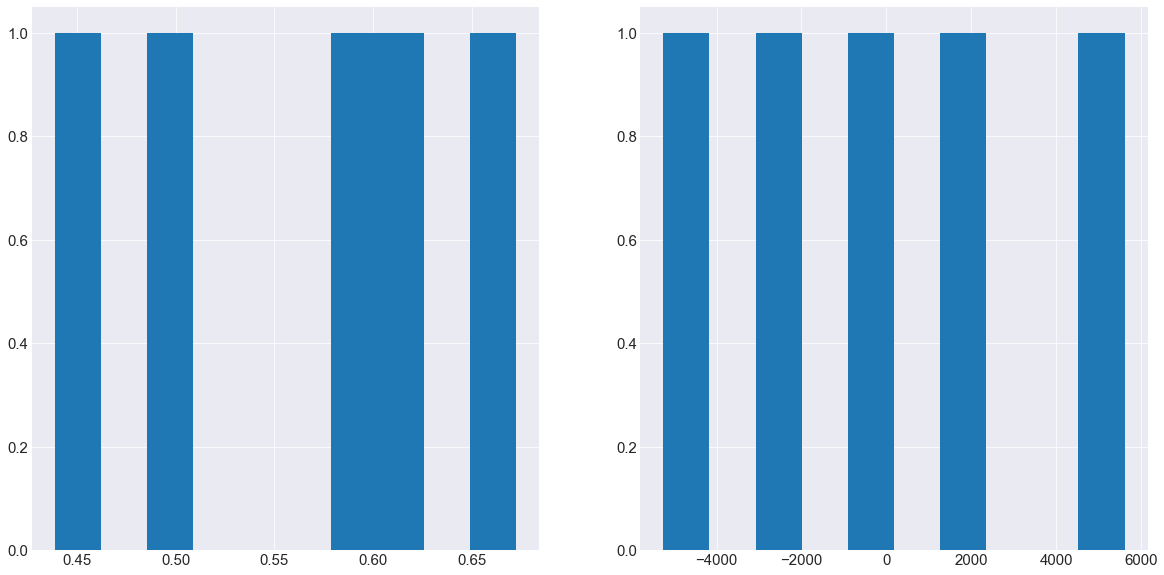

In [868]:
variance = cross_val_score(LR,X_train,y_train,cv=5,scoring=make_scorer(corr))
biass = cross_val_score(LR,X_train,y_train,cv=5,scoring=make_scorer(bias))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,10)
ax[0].hist( variance)
ax[1].hist(biass)

In [811]:
data_predict = split_dates_by_columns(data_predict, 'Date')
#For this early stage I discard type of Traffic and just sum all of them and group by Year, Month and Day
data_predict = data_predict.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()
#Reset Index after having made a groupby
data_predict = data_predict.reset_index()

KeyError: 'Date'

In [869]:
data_small

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2288,2021,4,7,26501,72689.94
2289,2021,4,8,24397,43742.25
2290,2021,4,9,23445,31925.36
2291,2021,4,10,15016,23028.97


In [870]:
data_predict

,Year,Month,Day,Visits,Revenue
0,2021,4,12,26209,65338.03
1,2021,4,13,26833,59898.32
2,2021,4,14,25334,55744.03
3,2021,4,15,26498,34730.98
4,2021,4,16,24250,32259.23
5,2021,4,17,16399,19334.21
6,2021,4,18,17315,9983.81
7,2021,4,19,26984,22452.18
8,2021,4,20,27327,19988.78
9,2021,4,21,22053,27774.11


In [871]:
data_neww = pd.concat([data_small, data_predict], ignore_index= True)

In [829]:
data_neww

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2316,2021,5,5,14373,37283.53
2317,2021,5,6,14025,39991.11
2318,2021,5,7,12399,24901.84
2319,2021,5,8,11018,15744.14


In [872]:
data_exp_predict = pd.DataFrame()
for i in range(365, 0 ,-1):
    data_exp_predict[f'Rev-{i}'] = data_neww["Revenue"].shift(i) #OJO que empieza en 0!
data_exp_predict['Revenue'] = data_neww["Revenue"]
data_exp_predict.dropna(inplace= True)
data_exp_predict

,Rev-365,Rev-364,Rev-363,Rev-362,Rev-361,Rev-360,Rev-359,Rev-358,Rev-357,Rev-356,Rev-355,Rev-354,Rev-353,Rev-352,Rev-351,Rev-350,Rev-349,Rev-348,Rev-347,Rev-346,Rev-345,Rev-344,Rev-343,Rev-342,Rev-341,Rev-340,Rev-339,Rev-338,Rev-337,Rev-336,Rev-335,Rev-334,Rev-333,Rev-332,Rev-331,Rev-330,Rev-329,Rev-328,Rev-327,Rev-326,Rev-325,Rev-324,Rev-323,Rev-322,Rev-321,Rev-320,Rev-319,Rev-318,Rev-317,Rev-316,...,Rev-49,Rev-48,Rev-47,Rev-46,Rev-45,Rev-44,Rev-43,Rev-42,Rev-41,Rev-40,Rev-39,Rev-38,Rev-37,Rev-36,Rev-35,Rev-34,Rev-33,Rev-32,Rev-31,Rev-30,Rev-29,Rev-28,Rev-27,Rev-26,Rev-25,Rev-24,Rev-23,Rev-22,Rev-21,Rev-20,Rev-19,Rev-18,Rev-17,Rev-16,Rev-15,Rev-14,Rev-13,Rev-12,Rev-11,Rev-10,Rev-9,Rev-8,Rev-7,Rev-6,Rev-5,Rev-4,Rev-3,Rev-2,Rev-1,Revenue
365,3244.55,4791.64,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,...,8349.37,4629.85,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55
366,4791.64,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,...,4629.85,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55,4017.26
367,534.93,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,2097.52,...,6299.61,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785.55,4017.26,2398.62
368,848.43,2393.52,47.60,4538.59,5145.28,2597.79,1244.15,1459.86,6131.74,6433.07,11098.82,8197.76,4424.75,1520.34,68.26,9858.20,9606.97,9042.06,5386.29,7778.88,3301.73,6108.41,3539.89,1541.51,8712.82,3927.55,2973.50,3541.61,3798.36,14127.02,9341.59,8365.48,3798.72,6412.43,1332.89,3889.47,3761.71,6062.70,8395.54,2560.52,1003.19,2769.12,2537.92,4684.87,2953.43,4363.87,11387.68,8573.08,2097.52,1081.02,...,8000.08,7348.44,9619.74,15449.38,6528.06,3236.58,4870.37,11138.20,16811.82,8590.85,16945.79,53466.09,15729.05,15766.39,46318.66,6183.26,5791.71,3040.05,7861.40,3028.04,3640.50,5166.16,9348.46,6859.72,6359.81,19858.14,1901.88,6113.54,11344.43,9056.82,18943.92,9932.98,8835.70,2631.54,8634.30,17169.00,18212.66,14478.67,9436.11,3158.21,1825.62,8008.34,16351.42,6407.68,9870.95,7688.27,6785

In [895]:
data_exp_predict.iloc[-20::1,:]

,Rev-365,Rev-364,Rev-363,Rev-362,Rev-361,Rev-360,Rev-359,Rev-358,Rev-357,Rev-356,Rev-355,Rev-354,Rev-353,Rev-352,Rev-351,Rev-350,Rev-349,Rev-348,Rev-347,Rev-346,Rev-345,Rev-344,Rev-343,Rev-342,Rev-341,Rev-340,Rev-339,Rev-338,Rev-337,Rev-336,Rev-335,Rev-334,Rev-333,Rev-332,Rev-331,Rev-330,Rev-329,Rev-328,Rev-327,Rev-326,Rev-325,Rev-324,Rev-323,Rev-322,Rev-321,Rev-320,Rev-319,Rev-318,Rev-317,Rev-316,...,Rev-49,Rev-48,Rev-47,Rev-46,Rev-45,Rev-44,Rev-43,Rev-42,Rev-41,Rev-40,Rev-39,Rev-38,Rev-37,Rev-36,Rev-35,Rev-34,Rev-33,Rev-32,Rev-31,Rev-30,Rev-29,Rev-28,Rev-27,Rev-26,Rev-25,Rev-24,Rev-23,Rev-22,Rev-21,Rev-20,Rev-19,Rev-18,Rev-17,Rev-16,Rev-15,Rev-14,Rev-13,Rev-12,Rev-11,Rev-10,Rev-9,Rev-8,Rev-7,Rev-6,Rev-5,Rev-4,Rev-3,Rev-2,Rev-1,Revenue
2301,45748.78,31375.19,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,...,73354.81,25111.77,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18,19988.78
2302,31375.19,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,...,25111.77,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18,19988.78,27774.11
2303,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,41321.59,...,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18,19988.78,27774.11,31266.89
2304,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,41321.59,32517.81,...,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,1256

In [896]:

X_real, y_real = data_preparation(data_exp_predict.iloc[-20::1,:])

In [897]:
X_real

,Rev-365,Rev-364,Rev-363,Rev-362,Rev-361,Rev-360,Rev-359,Rev-358,Rev-357,Rev-356,Rev-355,Rev-354,Rev-353,Rev-352,Rev-351,Rev-350,Rev-349,Rev-348,Rev-347,Rev-346,Rev-345,Rev-344,Rev-343,Rev-342,Rev-341,Rev-340,Rev-339,Rev-338,Rev-337,Rev-336,Rev-335,Rev-334,Rev-333,Rev-332,Rev-331,Rev-330,Rev-329,Rev-328,Rev-327,Rev-326,Rev-325,Rev-324,Rev-323,Rev-322,Rev-321,Rev-320,Rev-319,Rev-318,Rev-317,Rev-316,...,Rev-50,Rev-49,Rev-48,Rev-47,Rev-46,Rev-45,Rev-44,Rev-43,Rev-42,Rev-41,Rev-40,Rev-39,Rev-38,Rev-37,Rev-36,Rev-35,Rev-34,Rev-33,Rev-32,Rev-31,Rev-30,Rev-29,Rev-28,Rev-27,Rev-26,Rev-25,Rev-24,Rev-23,Rev-22,Rev-21,Rev-20,Rev-19,Rev-18,Rev-17,Rev-16,Rev-15,Rev-14,Rev-13,Rev-12,Rev-11,Rev-10,Rev-9,Rev-8,Rev-7,Rev-6,Rev-5,Rev-4,Rev-3,Rev-2,Rev-1
2301,45748.78,31375.19,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,...,44574.37,73354.81,25111.77,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18
2302,31375.19,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,...,73354.81,25111.77,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18,19988.78
2303,24097.79,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,41321.59,...,25111.77,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616.51,12567.89,17975.11,47948.93,31189.03,30698.42,58620.42,49929.23,12097.92,11609.60,24200.45,27270.11,63115.42,34052.84,29246.38,10881.45,9545.76,24509.59,42761.48,33827.68,11333.44,12551.94,5621.44,11002.49,18880.73,49956.80,72689.94,43742.25,31925.36,23028.97,16098.10,65338.03,59898.32,55744.03,34730.98,32259.23,19334.21,9983.81,22452.18,19988.78,27774.11
2304,56233.83,44289.34,26058.29,35085.70,49563.74,32508.93,29729.89,45575.59,47911.72,83723.62,63857.47,70477.28,75779.11,86168.34,65026.39,55038.17,46497.37,44445.49,73704.05,46740.12,44033.12,48864.90,46721.40,23687.67,35759.16,49408.64,41395.98,42344.30,32578.07,33590.29,15845.51,18983.99,59541.01,25035.17,43710.30,41252.52,30364.08,23845.18,19434.14,21849.04,43240.81,44915.54,73150.12,67009.97,29339.67,29671.71,37814.82,45465.30,41321.59,32517.81,...,71275.65,57090.77,21661.29,20541.04,38464.37,35589.54,25836.25,55832.23,37616

In [903]:
model = LR
y_pred = model.predict(X_real)
print(f'{type(model).__name__} | Predict MAE: {mean_absolute_error(y_real,y_pred):.4f}')
print(f'{type(model).__name__} | Predict RMSE: {np.sqrt(mean_squared_error(y_real,y_pred)):.4f}')
print(f'{type(model).__name__} | Predict R2: {r2_score(y_real,y_pred):.4f}')


LinearRegression | Predict MAE: 21265.7981
LinearRegression | Predict RMSE: 29182.1754
LinearRegression | Predict R2: -4.7768


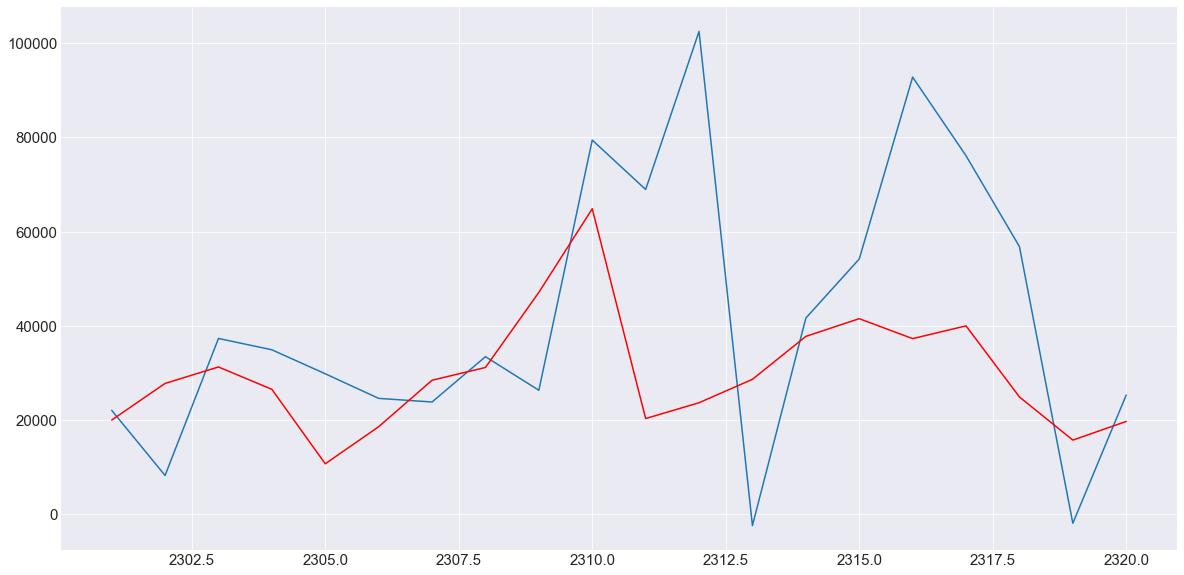

In [905]:
plt.plot(data_exp_predict.iloc[-20::1,:].index, y_pred)
plt.plot(data_exp_predict.iloc[-20::1,:].index, y_real, c='r')

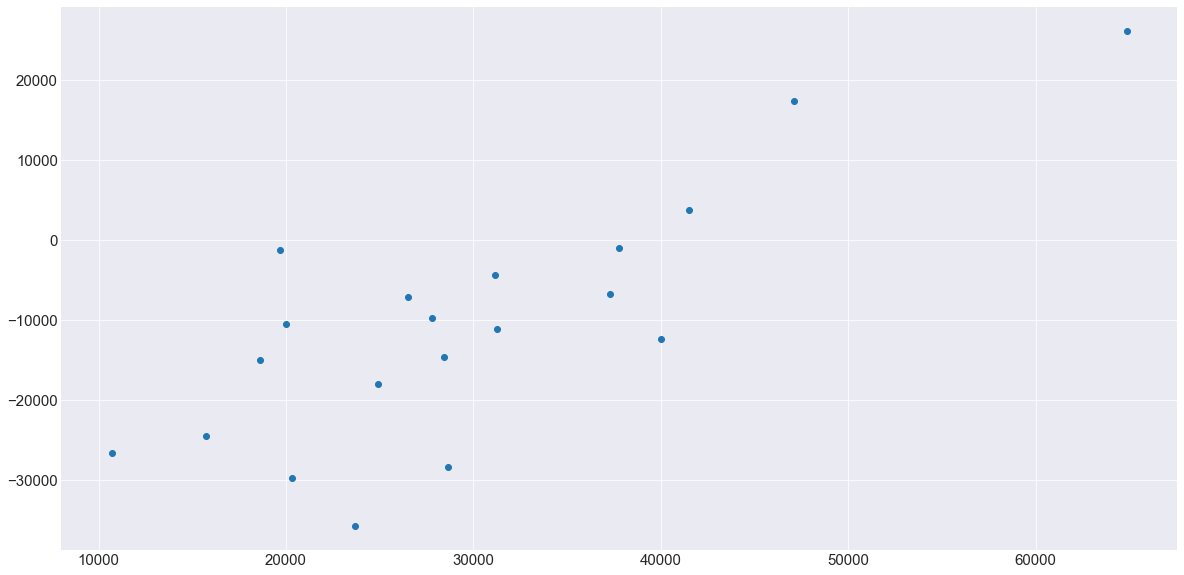

In [901]:
plt.scatter(y_real, y_real - y_pred)

In [792]:
X_real

,Rev-1,Rev-2,Rev-3,Rev-4,Rev-5,Rev-6,Rev-7,Rev-8,Rev-9,Rev-10,...,Rev-357,Rev-358,Rev-359,Rev-360,Rev-361,Rev-362,Rev-363,Rev-364,Rev-365,Revenue
1929,1.453576,-0.339158,0.103576,0.516689,0.924226,1.598839,1.099874,-0.136816,-0.788098,-1.565185,...,0.807828,1.280233,0.166114,-0.034039,1.414372,0.943711,-1.498295,-0.161984,0.463464,1.441114
